### 논문용 figure 코드 정리

#### Map(station_CC/heatmap) 
- zoom_start = 12,width = 1300, height = 1100,
**동일부분이 캡쳐되게 boundary 표시하고, heatmap scalebar 표시되게 할 것**
#### ~~Map(station_radius)~~
- zoom_start = 12,width = 1300, height = 1100,
    -**모든 역에 반경 ??m 원 표시되게** >> 모든 radius 다 저장해두기(appendex에 넣기)
#### Fig_double jointplot(CC)
    -**(A)(B)figure에 표시하자... 그대로 논문에 집어넣을 수 있게**
#### Fig_Scatter
    -**기존 데이터는 빼고 표에 따로 정리하도록 하자...**
#### Fig_Pearson
    -**2000,2500 포인트 broken_axis로 표시하고 전체 폭(비율) 잘 맞게 설정하자**
#### Fig_JSD
    -**위와 같음**


In [ ]:
#2 - Map(station_radius)
#! date 설정 해야 함!

import os, random, json, requests, folium
import pandas as pd
import seaborn as sns 
import scipy as sp
# import numpy as np
# import branca.colormap as cm
from matplotlib import pyplot as plt
from matplotlib import font_manager, rc
# from matplotlib.colors import to_hex
# from scipy import interpolate
# from scipy.interpolate import interp1d,UnivariateSpline
# from scipy.stats import *
from folium.plugins import HeatMap
# from geopy.distance import geodesic #몇개인지 세 주는 모듈
# from selenium import webdriver
import time
# from PIL import Image
# from sklearn.preprocessing import MinMaxScaler
rc('font', family = 'AppleGothic') #실행환경이 Mac일 경우
os.chdir(os.path.dirname('/Volumes/YAHO_/'))
station_coords = pd.read_excel('/Volumes/YAHO_/000. Processing Python/붕어빵/Inputs/20250205_서울시내 역(station_df, cent_df 통합).xlsx')
Starbucks_coords = pd.read_excel('/Volumes/YAHO_/006.일일 보관/INPUTS_update_0417/스타벅스_XY.xlsx')
TAI_coords = pd.read_excel('/Volumes/YAHO_/000. Processing Python/붕어빵/Inputs/20250203_dagn.xlsx')
count_tai = pd.read_excel('/Volumes/YAHO_/006.일일 보관/INPUTS_update_0417/붕어빵_300_2500_all_count_tai.xlsx')
count_star = pd.read_excel('/Volumes/YAHO_/006.일일 보관/INPUTS_update_0417/스타벅스_10_2500_all_count_tai.xlsx')
count_station = pd.read_excel('/Volumes/YAHO_/006.일일 보관/INPUTS_update_0417/역간 거리당 역개수_300_2500_all_count_station.xlsx')


date = input('저장명에 쓰일 날자를 입력(예시: May23)')
radius_m = input('모든 지하철 역을 기준으로 그릴 원의 반경(m)을 입력(예시 : 500)')

left,right,bottom,top = [37.433294,37.705133,126.784086,127.189311]

m = folium.Map(location = [(left+right)/2,(bottom+top)/2],#기본적인 지도생성
                tiles= 'cartodbpositron' ,attr  =None,
                zoom_start = 12,
                width = 1300, height = 1100,
                control_scale= True,
                png_enabled= True , overlay = True)
def seoul_border_line(m):
    left_bottom =[left, bottom]
    right_bottom =[right, bottom]
    left_top =[left, top]
    right_top =[right, top]
    folium.PolyLine([left_bottom, right_bottom],color="#000000",).add_to(m)
    folium.PolyLine([left_top, right_top],color="#000000",).add_to(m)
    folium.PolyLine([right_top, right_bottom],color="#000000",).add_to(m)
    folium.PolyLine([left_bottom, left_top],color="#000000",).add_to(m)
    
def coords_circlemarker(coords_df = station_coords):#!역 좌표 표시===
    for _,row in coords_df.iterrows(): #[역사명, 위도, 경도] column이 필요하다
        folium.CircleMarker(
            location = [(row["위도"]),(row["경도"])],
            popup=folium.Popup(row["역사명"], parse_html=True, max_width=100),
            radius = 3, color = 'purple' , weight = 0, fill = True , fillOpacity = 1
            ).add_to(m)
        folium.Circle(location = [(row["위도"]),(row["경도"])], 
            radius= radius_m,tooltip = str(row["역사명"]+' '+ f'{radius_m}m'),
            fillOpacity = 0.1,weight=2,color = 'blue', fill = False).add_to(m)
        
def tai_coords_circlemarker(tai_coords, m, color = 'red'): #!좌표 표시 tai 
    tai_layer = folium.FeatureGroup(name=f'{color}')
    for _,row in tai_coords.iterrows(): #[Address, Longitude, Latitude] column이 필요하다
        folium.CircleMarker(
            location = [(row["Longitude"]),(row["Latitude"])],
            popup=folium.Popup(row["Address"], parse_html=True, max_width=100),
            radius = 3, color = color , weight = 0, fill = True , fillOpacity = 0.9
            ).add_to(tai_layer)
    m.add_child(tai_layer)

def station_radius_layer(station_name, coords_df = station_coords, radius_m = 500):  #역 하나에 원 하나, 글씨 표시, zoom해서 보기 좋기      
    layer = folium.FeatureGroup(name=f'{station_name}_{radius_m}m')
    # count_layer = folium.FeatureGroup(name=f'{station_name}_{radius_m}m_count')
    coord = [coords_df.loc[coords_df['역사명'] == station_name, '위도'].iloc[0],
             coords_df.loc[coords_df['역사명'] == station_name, '경도'].iloc[0]
             ]
    count_tai_i  = count_tai.loc[count_tai['역사명'] == station_name, radius_m].iloc[0]
    count_star_i  = count_star.loc[count_star['역사명'] == station_name, radius_m].iloc[0]
    count_station_i  = count_station.loc[count_star['역사명'] == station_name, radius_m].iloc[0]
    # folium.Circle(location = coord, radius= 3000,
    #     tooltip = str(station_name +' '+ f'{radius_m}m'),fillOpacity = 0.1,
    #     color = 'blue', fill = False).add_to(layer)
    folium.Circle(location = coord, radius= radius_m,
        tooltip = str(station_name +' '+ f'{radius_m}m'),fillOpacity = 0.1,weight=2,
        color = 'blue', fill = False).add_to(layer)
    # folium.map.Marker(
    #     location=[coords+0.01 for coords in coord],
    #     icon=folium.DivIcon(
    #         icon_size=(85,36),
    #         icon_anchor=(8,20),
    #         html=f'<div style="background:white; font-size: 11pt">{station_name} {radius_m}m<br>\
    #         Bungeoppang : {count_tai_i}개<br>Starbucks: {count_star_i}개<br>근처 역 : {count_station_i}개</div>'
    #         )
    #         ).add_to(count_layer)
    m.add_child(layer)
    # m.add_child(count_layer)
    
def circle5_station(station_name, coords_df = station_coords, radius_m = 500): #!역간거리주의 radius_m +100씩
    layer = folium.FeatureGroup(name=f'{station_name}_{radius_m}m')
    count_layer = folium.FeatureGroup(name=f'{station_name}_{radius_m}m_count')
    coord = [coords_df.loc[coords_df['역사명'] == station_name, '위도'].iloc[0],
             coords_df.loc[coords_df['역사명'] == station_name, '경도'].iloc[0]
             ]
    for i in range(5):
        #fillOpacity 설정하면 범위가 더 잘 보인다
        radius = radius_m + 500*(4-i)
        folium.Circle(location = coord,
        radius = radius,#이렇게 설정해야 넓은 원부터 그려서 작은 원들의 툴팁이 정상적으로 표시됨
        tooltip = str(station_name +' '+ f'{radius}m'),fillOpacity = 0.0,
        color = 'purple', fill = True).add_to(layer)
        count_tai_i  = count_tai.loc[count_tai['역사명'] == station_name, radius].iloc[0]
        count_star_i  = count_star.loc[count_star['역사명'] == station_name, radius].iloc[0]
        count_station_i  = count_station.loc[count_star['역사명'] == station_name, radius].iloc[0]
        # print(count_tai)
        # 텍스트 레이블 추가
        # location은 아이콘 위치, anchor는 아이콘 위 텍스트 세부위치]
        # div style은 알아서 수정하기
        # folium.map.Marker(
        # location=[coords+0.016-0.004*i for coords in coord],
        # icon=folium.DivIcon(
        #     icon_size=(75,36),
        #     icon_anchor=(7,20),
        #     html=f'<div style="background:white; font-size: 8pt">{radius}m<br>\
        #     Bungeoppang : {count_tai_i}개<br>Starbucks: {count_star_i}개<br>근처 역 : {count_station_i}개</div>'
        #     )
        #     ).add_to(count_layer)
    m.add_child(count_layer)
    m.add_child(layer)
def BaseStation_radius_layer(station_name, coords_df = station_coords, radius_m = 3000):  #역 하나에 원 하나, 글씨 표시, zoom해서 보기 좋기      
    layer = folium.FeatureGroup(name=f'{station_name}_{radius_m}m')
    count_layer = folium.FeatureGroup(name=f'{station_name}_{radius_m}m_count')
    coord = [coords_df.loc[coords_df['역사명'] == station_name, '위도'].iloc[0],
             coords_df.loc[coords_df['역사명'] == station_name, '경도'].iloc[0]
             ]
    folium.Circle(location = coord, radius= 3000,
        tooltip = str(station_name +' '+ f'{radius_m}m'),fillOpacity = 0.1,
        color = 'blue', fill = False).add_to(layer)


    m.add_child(layer)
    m.add_child(count_layer)       


      
seoul_border_line(m)
coords_circlemarker(station_coords)
tai_coords_circlemarker(TAI_coords, m, color = 'red')
tai_coords_circlemarker(Starbucks_coords, m, color = 'green')

folium.LayerControl().add_to(m)

m.save(f"Station({radius_m}m)_Starbucks,Bungeoppang_{date}.html")


#### HeatMap (CC도 확인)


In [ ]:
import os, random, json, requests, folium
import pandas as pd
import seaborn as sns 
import scipy as sp
import numpy as np
import branca.colormap as cm
from matplotlib import pyplot as plt
from matplotlib import font_manager, rc
from matplotlib.colors import to_hex
from scipy import interpolate
from scipy.interpolate import interp1d,UnivariateSpline
from scipy.stats import *
from folium.plugins import HeatMap
from geopy.distance import geodesic #몇개인지 세 주는 모듈
from selenium import webdriver
import time
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

rc('font', family = 'AppleGothic') #실행환경이 Mac일 경우
# rc('font', family = 'Malgun Gothic') #실행환경이 Windows일 경우

#! 인허가 기반이니까 파일이름과 프랜차이즈 이름을 통일하자. 
#station_coords = pd.read_excel('20250205_서울시내 역(station_df, cent_df 통합).xlsx')
date = input("저장명에 쓰일 날짜 입력")
tai2 = 'Starbucks' #이런 식이면 될까
tai1 = 'Bungeoppang' 
tai1_coords = pd.read_excel('/Volumes/YAHO_/용도별 코드_Input포함/20250203_dagn.xlsx') #Bungeoppang 좌표

tai2_coords = pd.read_excel('/Volumes/YAHO_/용도별 코드_Input포함/스타벅스_XY.xlsx')
# tai_count = pd.read_excel(f'{tai}_all_count_tai.xlsx')
tai1_color = 'red'
tai2_color = 'green'

# ==================================

station_coords = pd.read_excel('/Volumes/YAHO_/용도별 코드_Input포함/20250205_서울시내 역(station_df, cent_df 통합).xlsx')

#서울시 경계선
# left = 37.443294
# right = 37.705133
# bottom = 126.784086
# top = 127.189311
left,right,bottom,top = [37.433294,37.705133,126.784086,127.189311]

m = folium.Map(location = [(left+right)/2,(bottom+top)/2],#기본적인 지도생성
                tiles= 'cartodbpositron' ,attr  =None,
                zoom_start = 12,
                width = 1300, height = 1100,
                control_scale= True,
                png_enabled= True , overlay = True)

def seoul_border_line(m):
    left_bottom =[left, bottom]
    right_bottom =[right, bottom]
    left_top =[left, top]
    right_top =[right, top]
    folium.PolyLine([left_bottom, right_bottom],color="#000000",).add_to(m)
    folium.PolyLine([left_top, right_top],color="#000000",).add_to(m)
    folium.PolyLine([right_top, right_bottom],color="#000000",).add_to(m)
    folium.PolyLine([left_bottom, left_top],color="#000000",).add_to(m)



def reset_m():
    m = folium.Map(location = [(left+right)/2,(bottom+top)/2],#지도 초기화
            tiles= 'cartodbpositron' ,attr  =None,
            zoom_start = 12,
            width = 1500, height = 1500)




def heatmap_tai(radius, min_opacity = 0.5, tai_coords = tai1_coords):
    heat_tai = folium.FeatureGroup(name=f'Heatmap (Toggle)') 
    data = []
    for i in tai_coords.iterrows():
        data.append([i[1]['Longitude'],i[1]['Latitude'],])
    colormap = cm.LinearColormap(colors = [
        'blue', 'cyan','lime','yellow', 'red'], vmin = 0, vmax = 10)
    colormap.caption = f'{radius}m 이내 분포수'
    colormap.tick_labels = ['0','5','10']
    colormap.add_to(m)
    # print(tai_data)
    # 히트맵 추가
    HeatMap(data, radius=radius, min_opacity= min_opacity).add_to(heat_tai)
    heat_tai.add_to(m)

def cent_circlemarker(coords_df = station_coords):#!역 좌표 표시===
    cc_layer = folium.FeatureGroup(name=f'closeness centrality')
    scaler = MinMaxScaler()
    centrality_data = np.array(coords_df['Closeness Centrality'])
    # print(centrality_data)
    normalized_centrality = scaler.fit_transform(centrality_data.reshape(-1, 1)).flatten()
    print(normalized_centrality)
    for index,row in coords_df.iterrows(): #[역사명, 위도, 경도] column이 필요하다
        # print(index)
        cent = normalized_centrality[index]
            # 근접 중심도 데이터 정규화를 바탕으로 raidus를 설정
        scaler = MinMaxScaler()
        folium.Circle(
            location = [(row["위도"]),(row["경도"])],
            popup=folium.Popup(row["역사명"], parse_html=True, max_width=100),
            radius = 1000*cent, color = 'blue' , weight = 0, fill = True , fillOpacity = 0.4
            ).add_to(cc_layer)
    m.add_child(cc_layer)
def heatmap_centrality(radius, min_opacity=0.5, coords_df=station_coords):
    heat_tai = folium.FeatureGroup(name=f'Heatmap (Toggle)') 
    scaler = MinMaxScaler()
    centrality_data = np.array(coords_df['Closeness Centrality'])
    # print(centrality_data)
    normalized_centrality = scaler.fit_transform(centrality_data.reshape(-1, 1)).flatten()
    print(normalized_centrality)
    data = []
    for index,row in coords_df.iterrows(): #[역사명, 위도, 경도] column이 필요하다
        # print(index)
        cent = normalized_centrality[index]
        data.append([row['위도'], row['경도'], normalized_centrality[index]])
    # for i in coords_df.iterrows():
    #     # 위도, 경도, 가중치 순서로 추가
    
    # 0-1 범위에 맞게 colormap 수정
    colormap = cm.LinearColormap(colors=[
        'blue', 'cyan','lime','yellow', 'red'], vmin=0, vmax=1)
    colormap.caption = 'Centrality Based Station Cluster Area ({1000}m)'
    colormap.tick_labels = ['0','0.5','1']
    colormap.add_to(m)
    
    # 히트맵 추가 - max_val 파라미터로 최대값 설정
    HeatMap(data, max_zoom= 12, radius=radius, 
            min_opacity=min_opacity, vmin = 0.0 , vmax = 1000).add_to(heat_tai)
    heat_tai.add_to(m)


def heatmap_Cent(station_coords, radius = 30, min_opacity = 0.5):
    data = []
    for _,row in station_coords.iterrows():
        data.append([row['위도'],row['경도'],row['Closeness Centrality']*10])
    print(data)
    heat_cent = folium.FeatureGroup(name='cent Heatmap (Toggle)') 
    HeatMap(data,name = 'cent_heatmap' ,radius= radius, 
    gradient = blue_gradient,
    max_zoom=13, vmin = 0 , vmax = 1,
    overlay=True, # 오버레이로 설정
).add_to(heat_cent)
    # heat_red.add_to(m)
    m.add_child(heat_cent)
    


  
def coords_circlemarker(coords_df = station_coords):#!역 좌표 표시===
    for _,row in coords_df.iterrows(): #[역사명, 위도, 경도] column이 필요하다
        folium.CircleMarker(
            location = [(row["위도"]),(row["경도"])],
            popup=folium.Popup(row["역사명"], parse_html=True, max_width=100),
            radius = 4, color = 'purple' , weight = 0, fill = True , fillOpacity = 1
            ).add_to(m)
def tai_coords_circlemarker(tai_coords, m, color = 'red'): #!좌표 표시 tai 
    for _,row in tai_coords.iterrows(): #[Address, Longitude, Latitude] column이 필요하다
        folium.CircleMarker(
            location = [(row["Longitude"]),(row["Latitude"])],
            popup=folium.Popup(row["Address"], parse_html=True, max_width=100),
            radius = 3, color = color , weight = 0, fill = True , fillOpacity = 0.5
            ).add_to(m)
        # print(f'{row["Address"]}is added')
        
# tai_coords = pd.read_excel('20250203_dagn.xlsx')
# seoul_border_line(m)

# tai_coords['Address'] = tai_coords['소재지전체주소']
# tai_coords_circlemarker(tai1_coords, m , color = tai1_color)
# heatmap_tai(20,0.25, tai1_coords)
coords_circlemarker()
heatmap_centrality(30,min_opacity=0, coords_df = station_coords)



# Layer Control 추가

# CSS 스타일을 추가하여 TileLayer의 투명도를 조절

# folium.LayerControl().add_to(m)

m.save(f"Heatmap_{date}.html")





[0.66033637 0.76980246 0.6606595  0.6606595  0.66373523 0.56355647
 0.70016981 0.55170822 0.5738314  0.81456951 0.45140601 0.50827894
 0.53280343 0.43028402 0.70152386 0.55085845 0.4554022  0.48073782
 0.60137832 0.4346557  0.57967779 0.53308025 0.46853765 0.47544858
 0.54958547 0.62753947 0.50989029 0.53404989 0.68690994 0.64703344
 0.62831686 0.55996936 0.63315282 0.57543498 0.73027476 0.65502241
 0.51177441 0.68093374 0.76597128 0.72678199 0.67466989 0.75727445
 0.87909385 0.61872767 0.76197489 0.67878574 0.71793702 0.73536369
 0.76197489 0.66422188 0.72312927 0.59045645 0.84024962 0.65856138
 0.87991578 0.566582   0.78826976 0.49748858 0.74367322 0.59687236
 0.4015503  0.69326299 0.47300981 0.7217417  0.51922047 0.72312927
 0.5411503  0.78752389 0.93184365 0.82015148 0.52112716 0.63315282
 0.79032402 0.49828276 0.59552536 0.73413268 0.76925416 0.42161726
 0.50600187 0.42545662 0.87376834 0.47866938 0.60333855 0.91358862
 0.89087263 0.60409372 0.82015148 0.48164452 0.35260451 0.8499

### Centrality 계산값 확인
    - /받 자료의 역 파일과 자료의 centrality 계산 파일을 이용해서 networkx 의 CC계산이 improved CC(by Wasserman and Faust)인지 확인하자.

In [ ]:
from pandas import read_excel, DataFrame
from collections import Counter
import networkx as nx
from networkx.algorithms import community
from scipy.stats import entropy
import pandas as pd
import numpy as np

# 데이터 불러오기
# file_path = '/Volumes/YAHO_/용도별 코드_Input포함/seoul_station copy.xlsx' v.0.1
file_path = '/Volumes/YAHO_/006.일일 보관/붕어빵 논문_May24/250411_수도권 지하철 노선도_서울교통공사사이버스테이션_9호선급행추가_시트정리_May24.xlsx' # v0.2
output_file_path = '/Volumes/YAHO_/006.일일 보관/붕어빵 논문_May24/seoul_subway_network_data_v0.2.xlsx'
output_file_path_multi = '/Volumes/YAHO_/006.일일 보관/붕어빵 논문_May24/seoul_subway_centrality_analysis_multi_v0.2.xlsx'
seoul_station_data = read_excel(file_path)

# 데이터프레임 생성
network_data = DataFrame({
    'station': seoul_station_data['Station_Name'],
    'next_station': seoul_station_data['Next_station'],
    'index': seoul_station_data['index'],
    'route_type_id': seoul_station_data['routeType_name']
})

# 데이터 저장
network_data.to_excel(output_file_path, index=False)

# 기본 통계 분석
total_stations = network_data['station'].nunique()
unique_stations = network_data['station'].unique()
unique_route_types = network_data['route_type_id'].nunique()

# 네트워크 분석
connection_counts = Counter(network_data['station'])

# 가장 많은 역과 연결된 역
most_connected_station = connection_counts.most_common(1)

# 각 루트 유형별 역의 수 계산
route_type_station_count = network_data.groupby('route_type_id')['station'].nunique()

# "next_station"이 없는 역 찾기
missing_next_station = network_data[network_data['next_station'].isna()]

# "next_station"이 없는 역들에 대한 기본 통계 계산
total_missing_next_station = missing_next_station['station'].nunique()
missing_next_station_count_by_route = missing_next_station.groupby('route_type_id')['station'].count().reset_index()

# 데이터 다시 불러오기
network_data = pd.read_excel(output_file_path)

# MultiGraph 객체 생성
G_multi = nx.MultiGraph()

# 노드 추가
stations = network_data['station'].unique()
for station in stations:
    G_multi.add_node(station)

# 엣지 추가
edges = network_data[['station', 'next_station', 'route_type_id']].dropna().values
for edge in edges:
    G_multi.add_edge(edge[0], edge[1], route=edge[2])

# 네트워크 전체 지표 계산을 위한 준비
connected_components = list(nx.connected_components(G_multi))
largest_connected_component = max(connected_components, key=len)
subgraph = G_multi.subgraph(largest_connected_component)

# 네트워크 전체 지표 계산
N = G_multi.number_of_nodes()  # Number of stations
M = G_multi.number_of_edges()  # Number of links
D = nx.diameter(subgraph)  # Network diameter
r_G = nx.radius(subgraph)  # Radius
L = nx.average_shortest_path_length(subgraph)  # Average shortest path

# 클러스터링 계수 계산
G_simple = nx.Graph(G_multi)
clustering_coefficient = nx.average_clustering(G_simple)

# 커뮤니티 탐지 및 모듈러리티 계산
communities = community.greedy_modularity_communities(G_simple)
Q = community.modularity(G_simple, communities)  # Modularity
number_of_communities = len(communities)  # Number of communities

# 어쏘시에티비티 계산
assortativity = nx.degree_assortativity_coefficient(G_simple)

# Entropy 계산
degree_sequence = [d for n, d in G_multi.degree()]
degree_counts = np.bincount(degree_sequence)
degree_probability = degree_counts / sum(degree_counts)
entropy_value = entropy(degree_probability, base=2)

# 결과 반환
network_analysis_result = pd.DataFrame({
    "Metric": ["Number of stations (N)", "Number of links (M)", "Network diameter (D)", "Radius (r(G))", "Average shortest path (L)", "Clustering coefficient", "Modularity (Q)", "Number of communities", "Assortativity", "Entropy (E)"],
    "Value": [N, M, D, r_G, L, clustering_coefficient, Q, number_of_communities, assortativity, entropy_value]
})

# 중심성 계산
centrality_data_multi = pd.DataFrame({
    'Station': list(G_multi.nodes),
    'Degree Centrality': list(nx.degree_centrality(G_multi).values()),
    'Closeness Centrality_Basic': list(nx.closeness_centrality(G_multi,wf_improved=False).values()),
    'Closeness Centrality_WF': list(nx.closeness_centrality(G_multi).values()),
    'Betweenness Centrality': list(nx.betweenness_centrality(G_simple).values()),
    'Eigenvector Centrality': list(nx.eigenvector_centrality_numpy(G_multi).values())
})

# centrality 데이터를 엑셀 파일로 저장
centrality_data_multi.to_excel(output_file_path_multi, index=False)

# 결과 출력
print("가장 많이 연결된 역:", most_connected_station)
print("루트 유형별 역의 수:")
print(route_type_station_count.reset_index())
print("next_station이 없는 전체 역의 수:", total_missing_next_station)
print("각 노선별로 next_station 이 없는 역의 개수: ")
print(missing_next_station_count_by_route)
print(network_analysis_result)
print(centrality_data_multi)

가장 많이 연결된 역: [('청량리역', 4)]
루트 유형별 역의 수:
   route_type_id  station
0            1호선       79
1        1호선 외선1       22
2        1호선 외선2        2
3        1호선 외선3        2
4         2호선 내선       43
5        2호선 외선1        5
6        2호선 외선2        5
7            3호선       42
8            4호선       51
9            5호선       38
10        5호선 외선       18
11           6호선       39
12           7호선       53
13           8호선       18
14      8호선(별내선)        6
15           9호선       38
16           경강선       12
17         경의중앙선       34
18   경의중앙선 서울역라인       22
19           경춘선       24
20        경춘선 외선        2
21         공항철도선       14
22        김포도시철도       10
23           서해선       18
24         수인분당선       63
25           신림선       10
26          신분당선       16
27         용인경전철       15
28       우이신설경전철       13
29        의정부경전철       15
30         인천1호선       30
31         인천2호선       27
next_station이 없는 전체 역의 수: 26
각 노선별로 next_station 이 없는 역의 개수: 
   route_type_id  station
0        1호선 외

In [29]:
import pandas as pd
#노선명/정거장구성(,) 으로 제대로 된 시트 초안 만들기
Input_File_Path = '/Volumes/YAHO_/006.일일 보관/붕어빵 논문_May24/250411_수도권 지하철 노선도_서울교통공사사이버스테이션_9호선급행추가_시트정리_May24.xlsx'
Output_File_Path = '/Volumes/YAHO_/006.일일 보관/Seoul_Station_250411_수도권 지하철 노선도_서울교통공사사이버스테이션_May24.xlsx'

DF = pd.read_excel(Input_File_Path, sheet_name= 'Sheet1')
print(DF)
for column,row in DF.iterrows():
    stations= row['정거장구성']
    print(f'======={row['노선명']}=시작========')
    for station in stations.split(','):
        print(f'{station}')
    print(f'======={row['노선명']}=========')
    for station in stations.split(','):
        print(f'{station}역')
    print(f'=======끝=========')


# stations= input(',로 구분된 역 집어넣기')
# print(stations)
# station_list = [item.split(',')[-1] if ',' in item else item for item in stations]
# station_list = [item.split(',')[-1] for item in stations]
# print(station_list)
# for station in stations.split(','):
#     print(f'{station}')
# print('================')
# for station in stations.split(','):
#     print(f'{station}역')

          노선명                                              정거장구성
0        1호선   연천,전곡,청산,소요산,동두천,보산,동두천중앙,지행,덕정,덕계,양주,녹양,가능,의정...
1     1호선 외선1  인천,동인천,도원,제물포,도화,주안,간석,동암,백운,부평,부개,송내,중동,부천,소사...
2     1호선 외선2                                            금천구청,광명
3     1호선 외선3                                             병점,서동탄
4      2호선 내선  신도림,문래,영등포구청,당산,합정,홍대입구,신촌,이대,아현,충정로,시청,을지로입구,...
5     2호선 외선1                             신도림,도림천,양천구청,신정네거리,까치산
6     2호선 외선2                                    성수,용답,신답,용두,신설동
7         3호선  대화,주엽,정발산,마두,백석,대곡,화정,원당,원흥,삼송,지축,구파발,연신내,불광,녹...
8         4호선  진접,오남,별내별가람,불암산,상계,노원,창동,쌍문,수유,미아,미아사거리,길음,성신여...
9         5호선  방화,개화산,김포공항,송정,마곡,발산,우장산,화곡,까치산,신정,목동,오목교,양평,영...
10     5호선 외선  하남검단산,하남시청,하남풍산,미사,강일,상일동,고덕,명일,굽은다리,길동,강동,둔촌동...
11        6호선  신내,봉화산,화랑대,태릉입구,석계,돌곶이,상월곡,월곡,고려대,안암,보문,창신,동묘앞...
12        7호선  석남,산곡,부평구청,굴포천,삼산체육관,상동,부천시청,신중동,춘의,부천종합운동장,까치...
13        8호선  별내,다산,동구릉,구리,장자호수공원,암사역사공원,암사,천호,강동구청,몽촌토성,잠실,...
14        9호선  개화,김포공항,공항

In [47]:
#cent통합 시트에 있는 역들 위 초안시트에 '서울' 집어넣기
# Old_Station_excel_path = '/Volumes/YAHO_/용도별 코드_Input포함/20250205_서울시내 역(station_df, cent_df 통합).xlsx'
# New_Station_excel_path= '/Volumes/YAHO_/006.일일 보관/붕어빵 논문_May24/250411_수도권 지하철 노선도_서울교통공사사이버스테이션_9호선급행추가_시트정리_May24.xlsx'
Output_excel_path= '/Volumes/YAHO_/006.일일 보관/붕어빵 논문_May24/seoul_subway_May24_1.xlsx'

Seoul_Station_DF = pd.read_excel('/Volumes/YAHO_/용도별 코드_Input포함/20250205_서울시내 역(station_df, cent_df 통합).xlsx')
df = pd.read_excel('/Volumes/YAHO_/006.일일 보관/붕어빵 논문_May24/seoul_subway_centrality_analysis_multi_v0.1.xlsx')
# print(Seoul_Station_DF)
# print(df)

#역사명을 가져와서 만약 있으면 city_name : '서울'
seoul_station_list = Seoul_Station_DF['Station'].to_list()
# print(seoul_station_list)
df.loc[df['Station'].isin(seoul_station_list), "city_name"] = '서울'
df.to_excel(Output_excel_path,index=False)



## JointPlot
- fig 3의 jointplot(double)

300m || bandwidth_y1: 0.6825920916723746, bandwidth_y2: 0.4518306999374633


/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main1.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거
/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:149: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main2.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거


400m || bandwidth_y1: 0.8269371386037399, bandwidth_y2: 0.6071103653260302


/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main1.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거
/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:149: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main2.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거


500m || bandwidth_y1: 0.9744306889590255, bandwidth_y2: 0.8226000920430481


/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main1.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거
/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:149: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main2.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거


600m || bandwidth_y1: 1.1562020940062332, bandwidth_y2: 1.08914794713376


/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main1.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거
/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:149: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main2.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거


700m || bandwidth_y1: 1.370890207986178, bandwidth_y2: 1.3855080062859408


/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main1.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거
/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:149: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main2.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거


800m || bandwidth_y1: 1.6322752922109773, bandwidth_y2: 1.6827300760664667


/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main1.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거
/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:149: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main2.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거


900m || bandwidth_y1: 1.9891286106429915, bandwidth_y2: 1.9298519076781708


/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main1.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거
/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:149: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main2.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거


1000m || bandwidth_y1: 2.2914218577557053, bandwidth_y2: 2.227350260356393


/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main1.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거
/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:149: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main2.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거


1100m || bandwidth_y1: 2.6084302897350273, bandwidth_y2: 2.5878465384534395


/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main1.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거
/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:149: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main2.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거


1200m || bandwidth_y1: 2.9384445566555355, bandwidth_y2: 2.9417710462742273


/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main1.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거
/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:149: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main2.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거


1300m || bandwidth_y1: 3.231329904755882, bandwidth_y2: 3.335253525746652


/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main1.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거
/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:149: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main2.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거


1400m || bandwidth_y1: 3.6071892821943035, bandwidth_y2: 3.637871880258308


/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main1.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거
/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:149: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main2.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거


1500m || bandwidth_y1: 3.9501635485954854, bandwidth_y2: 4.033711815718138


/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main1.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거
/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_22348/761139929.py:149: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main2.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거


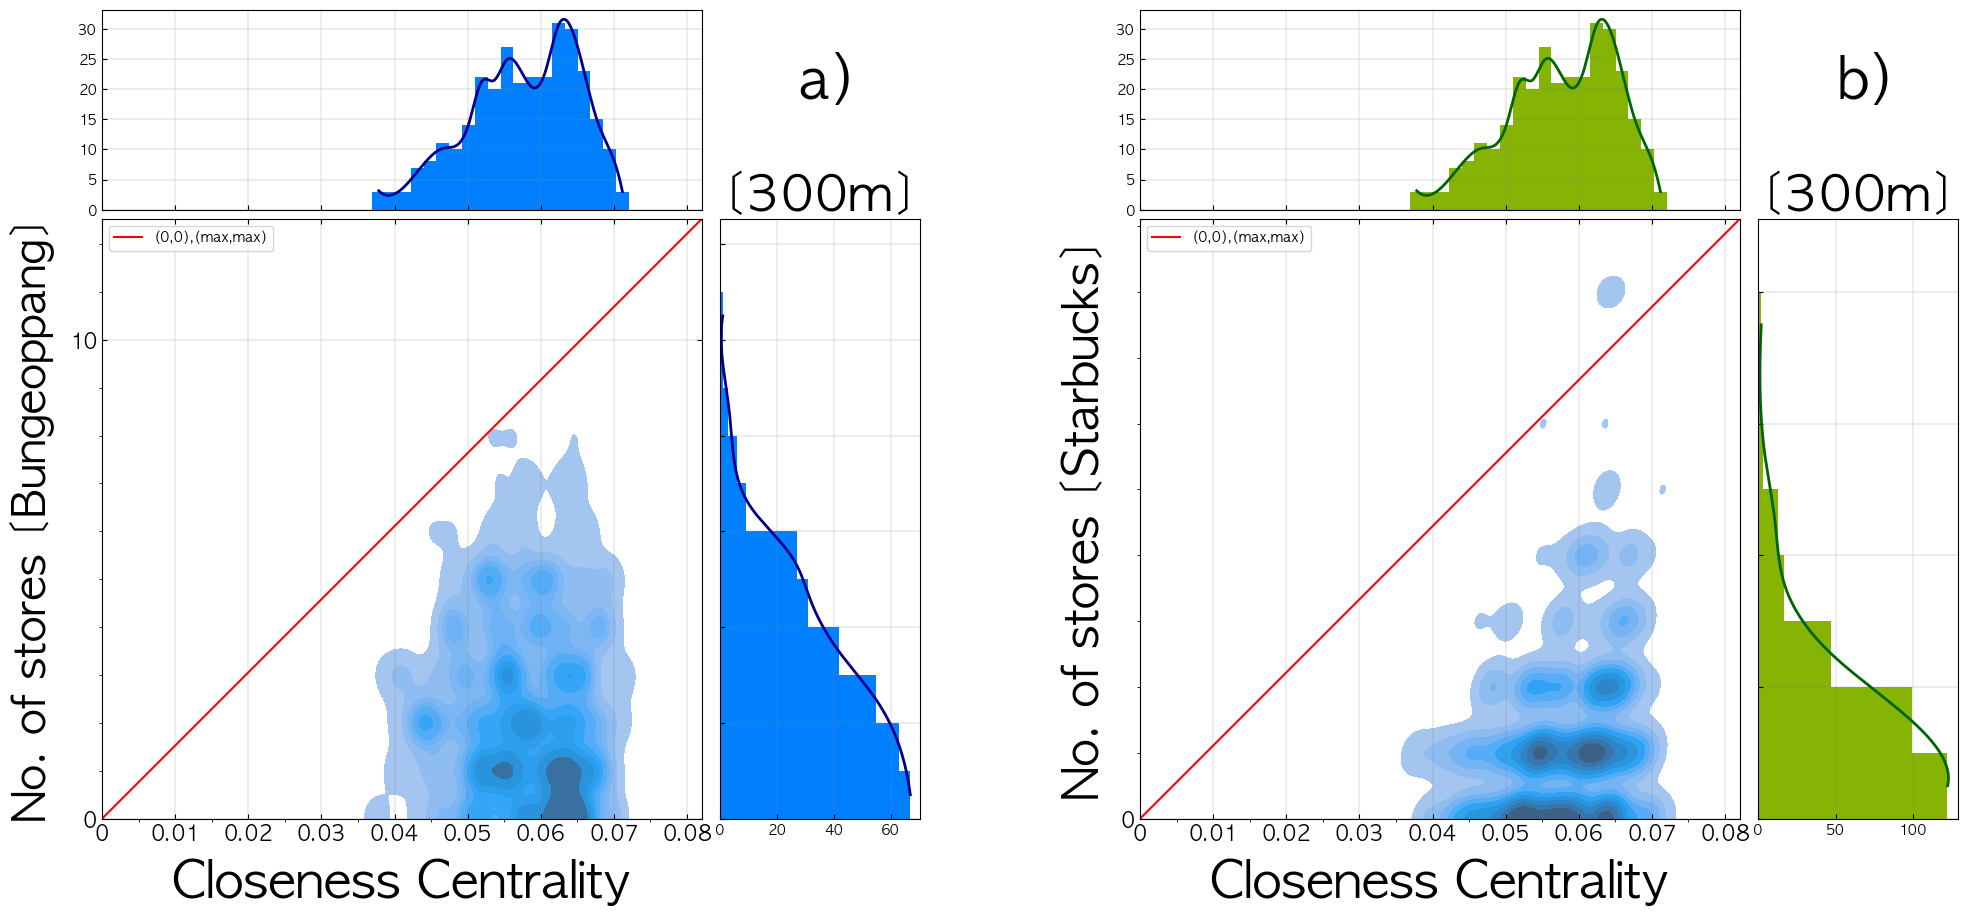

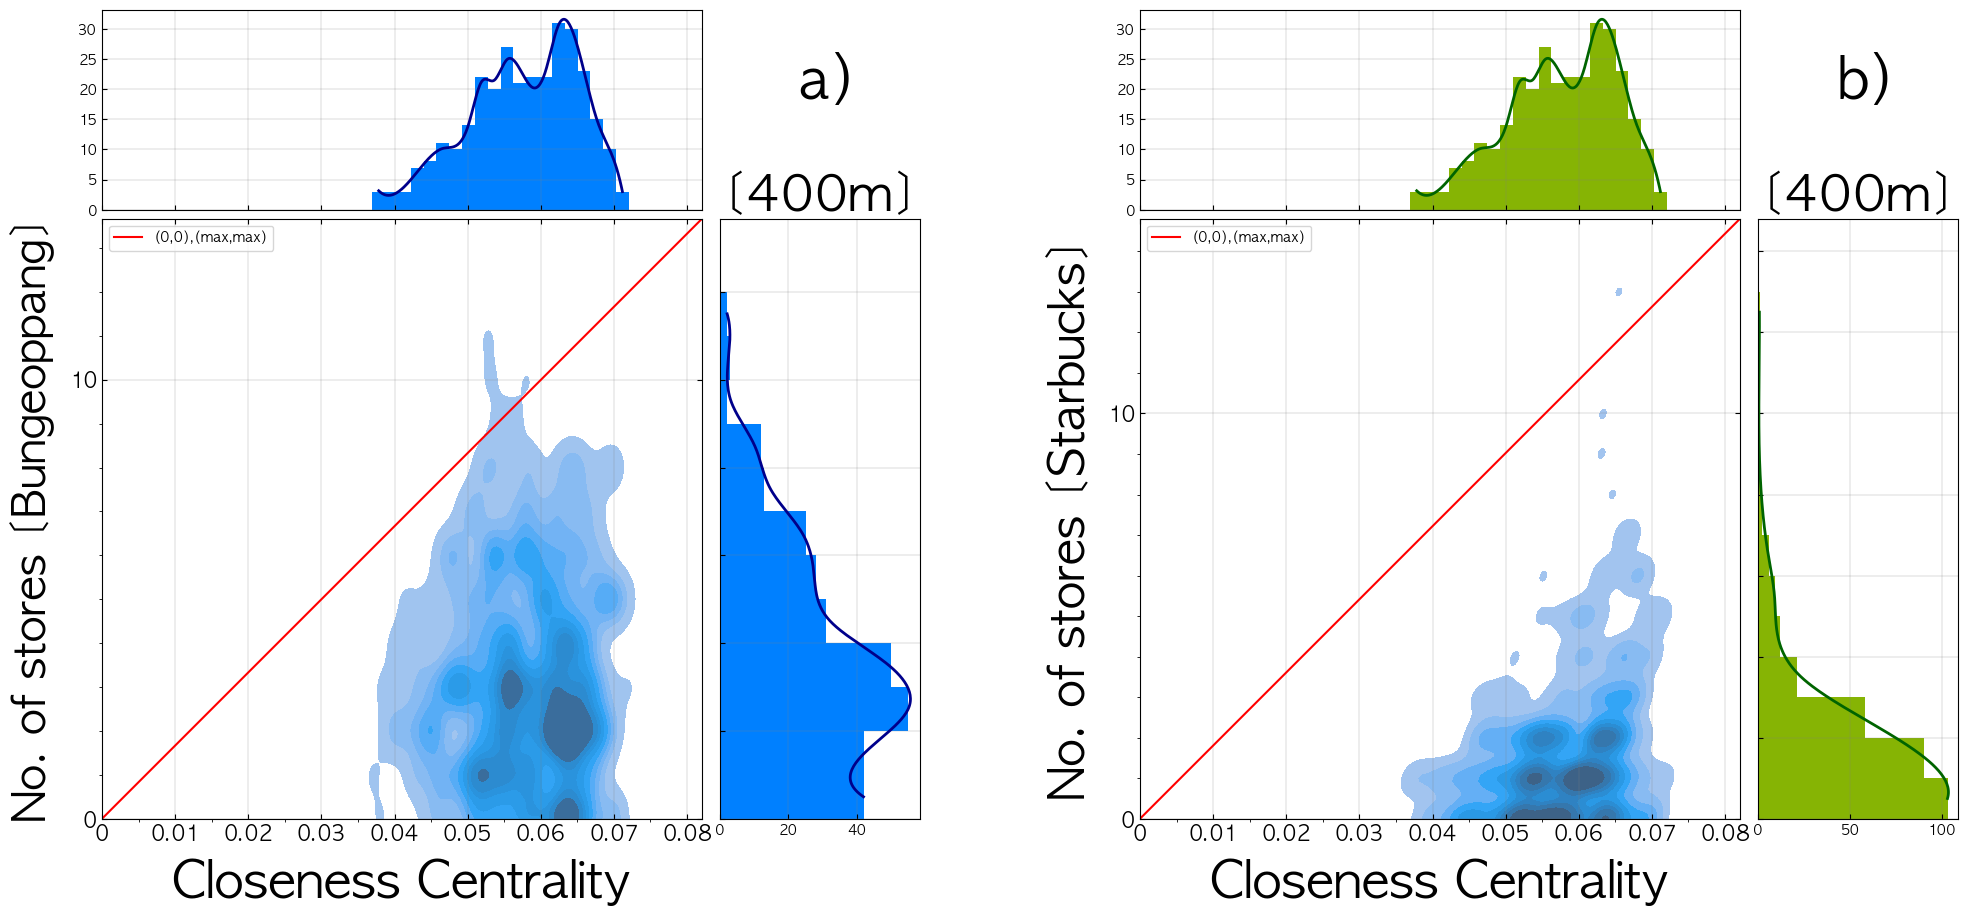

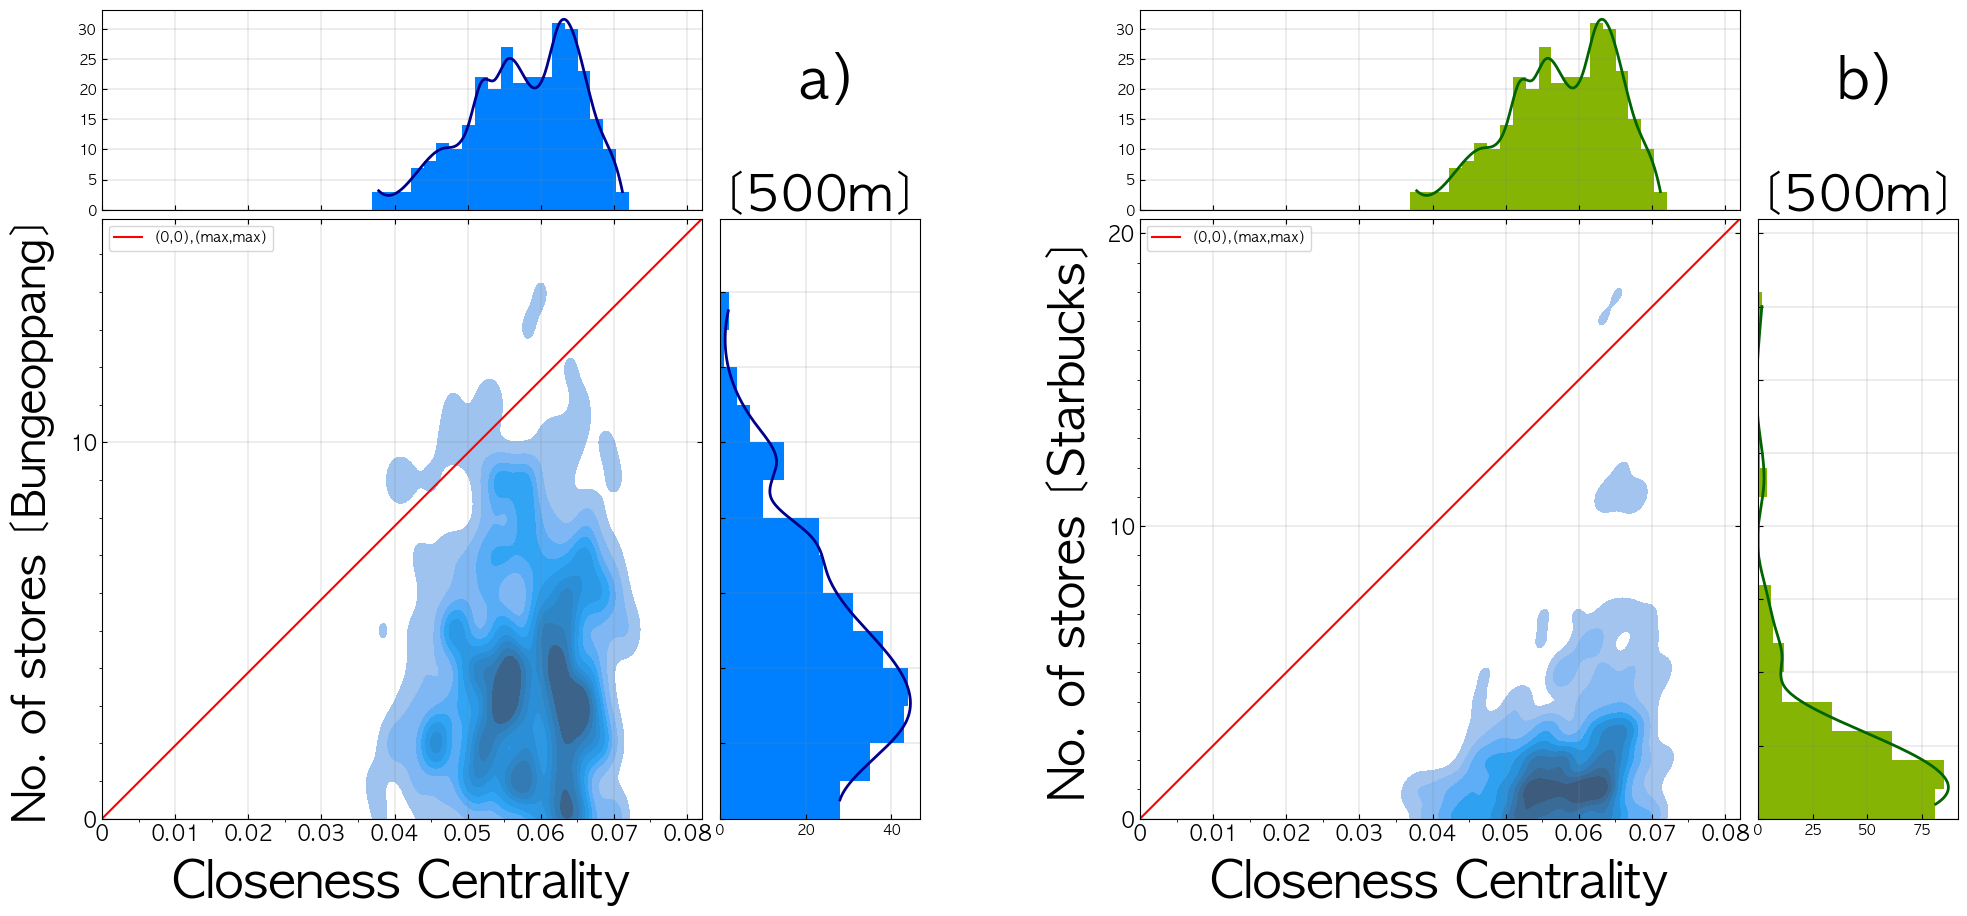

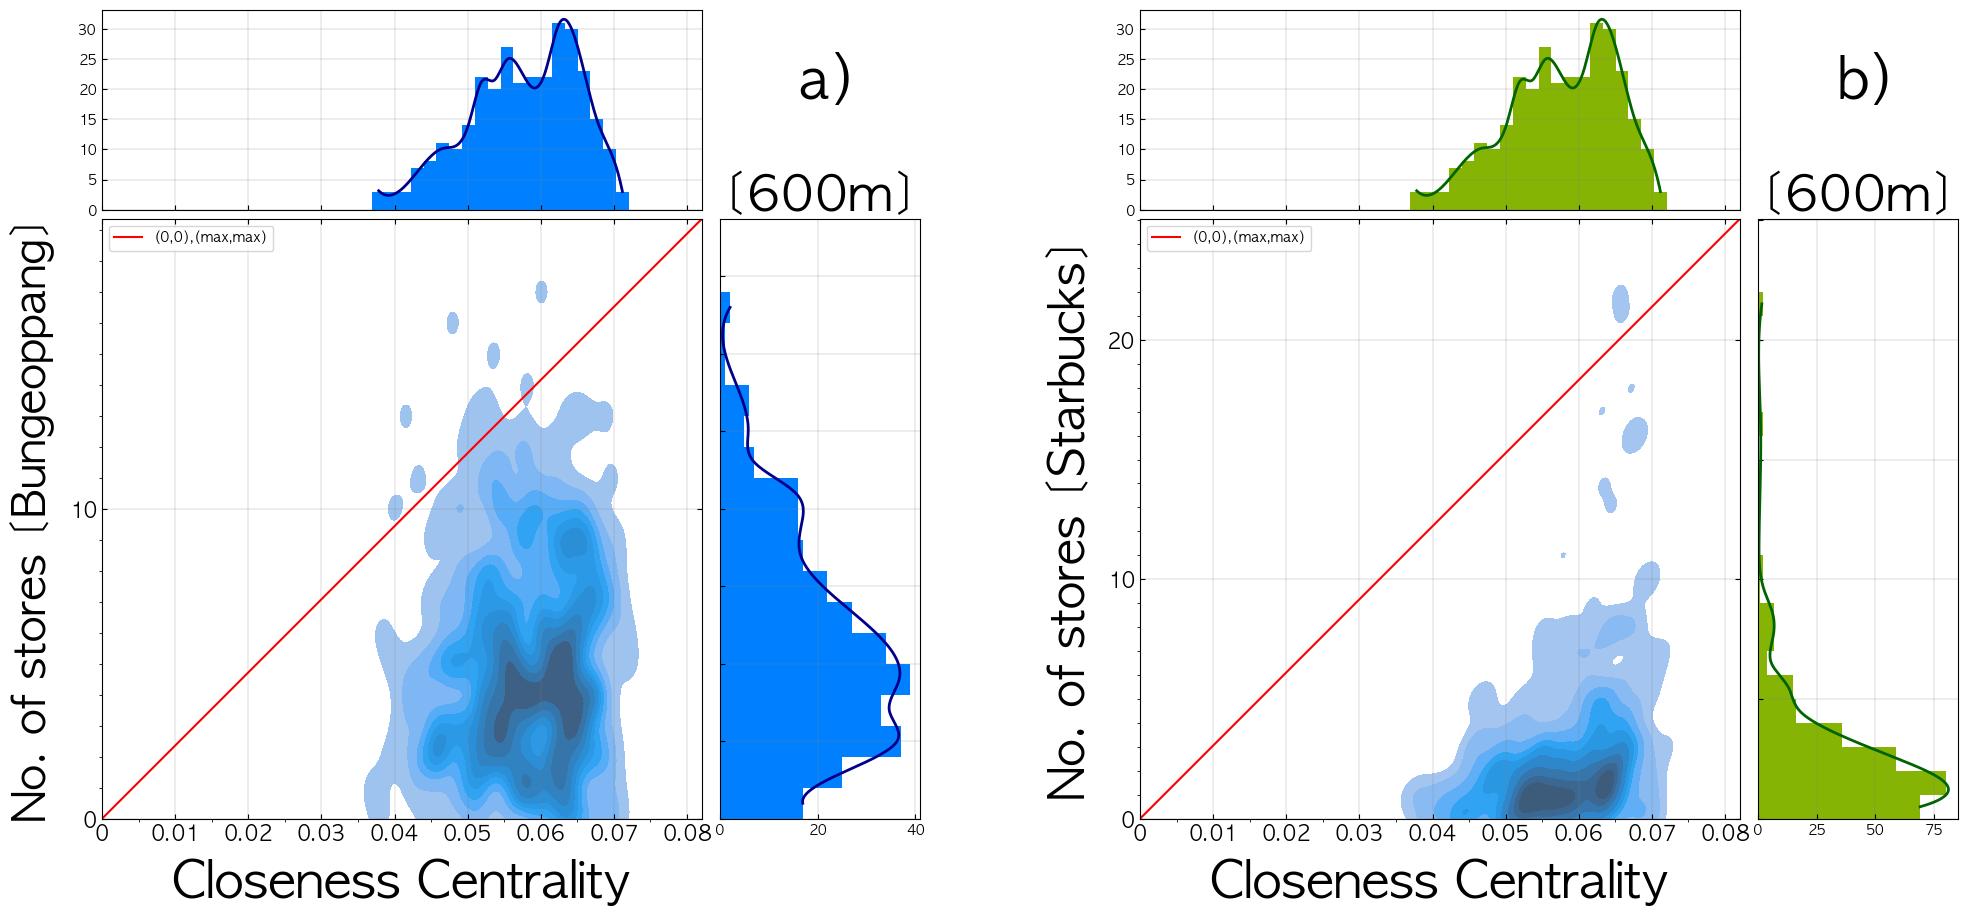

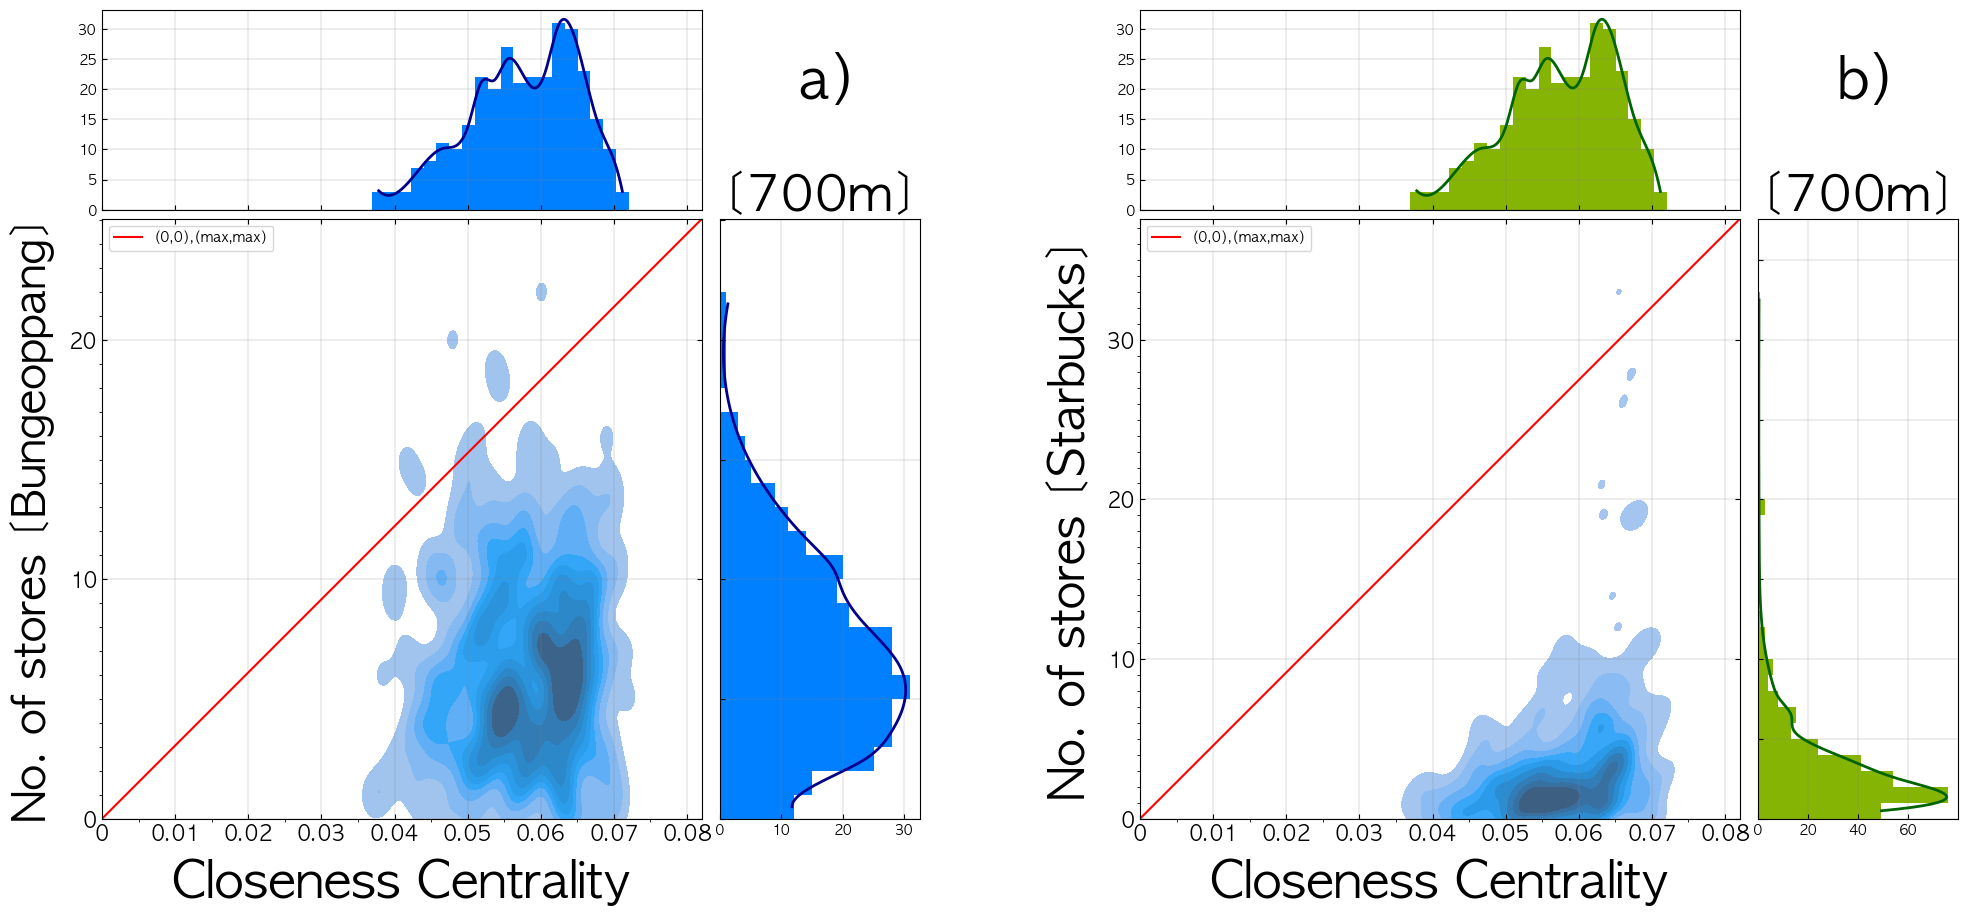

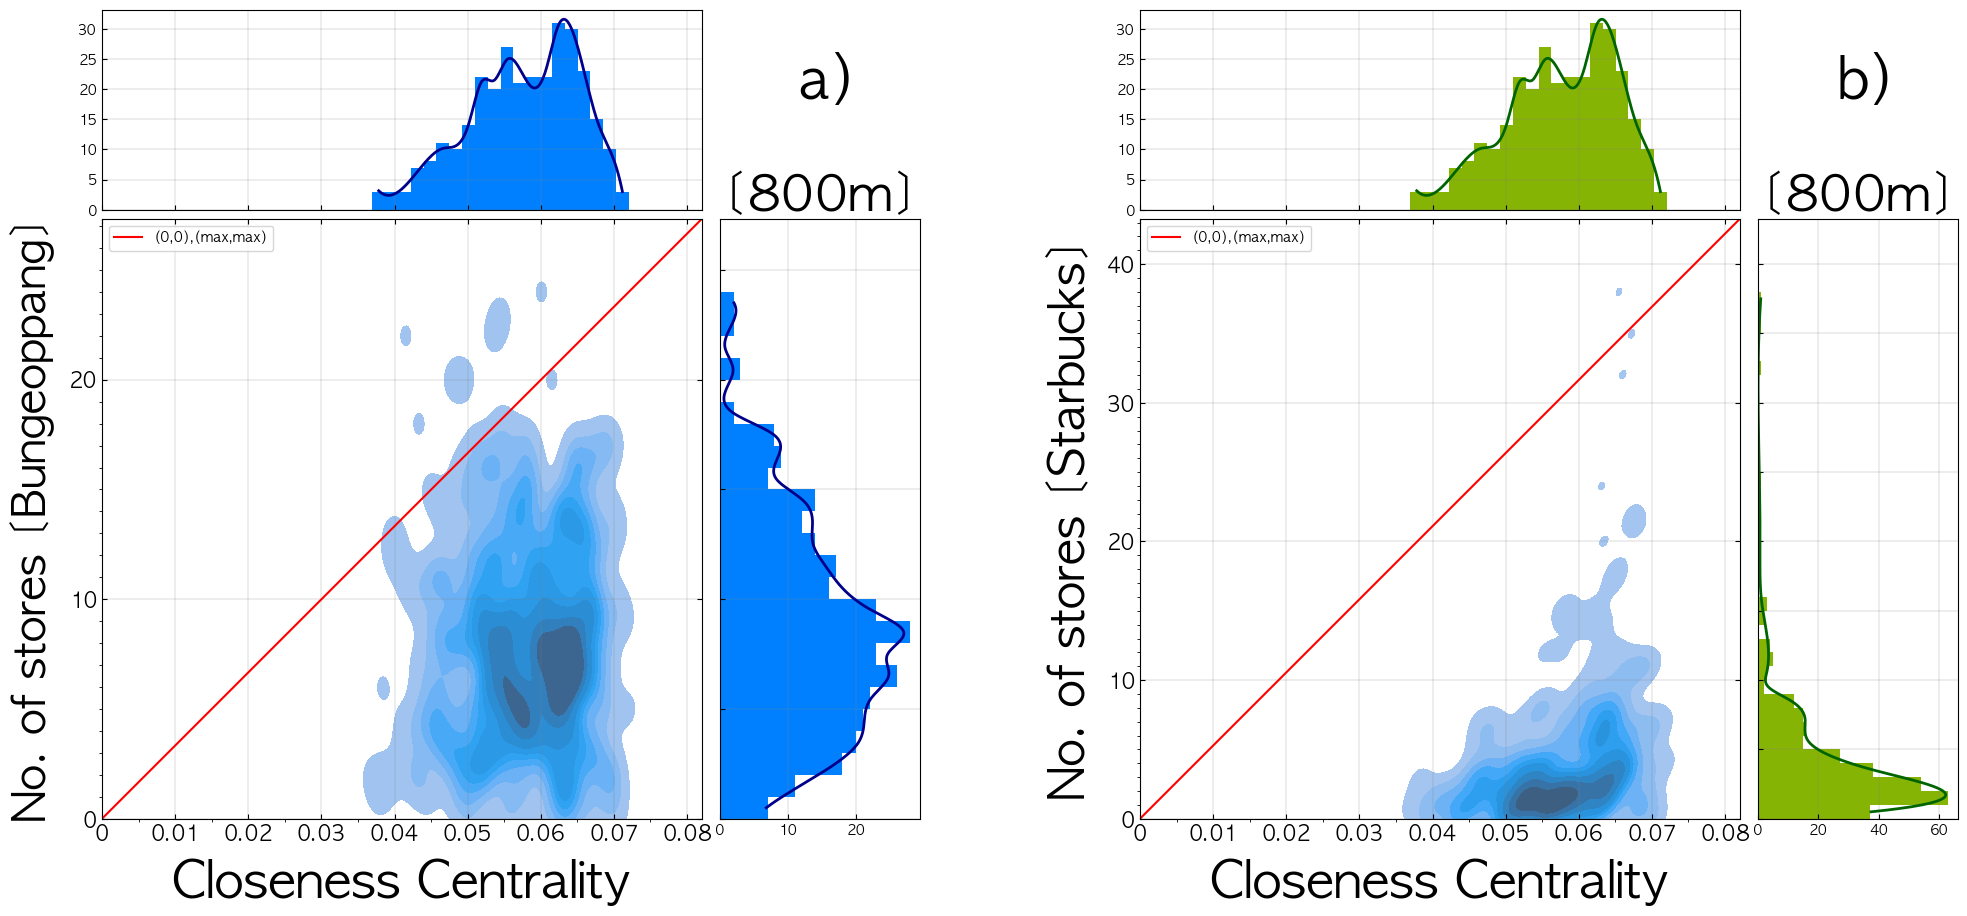

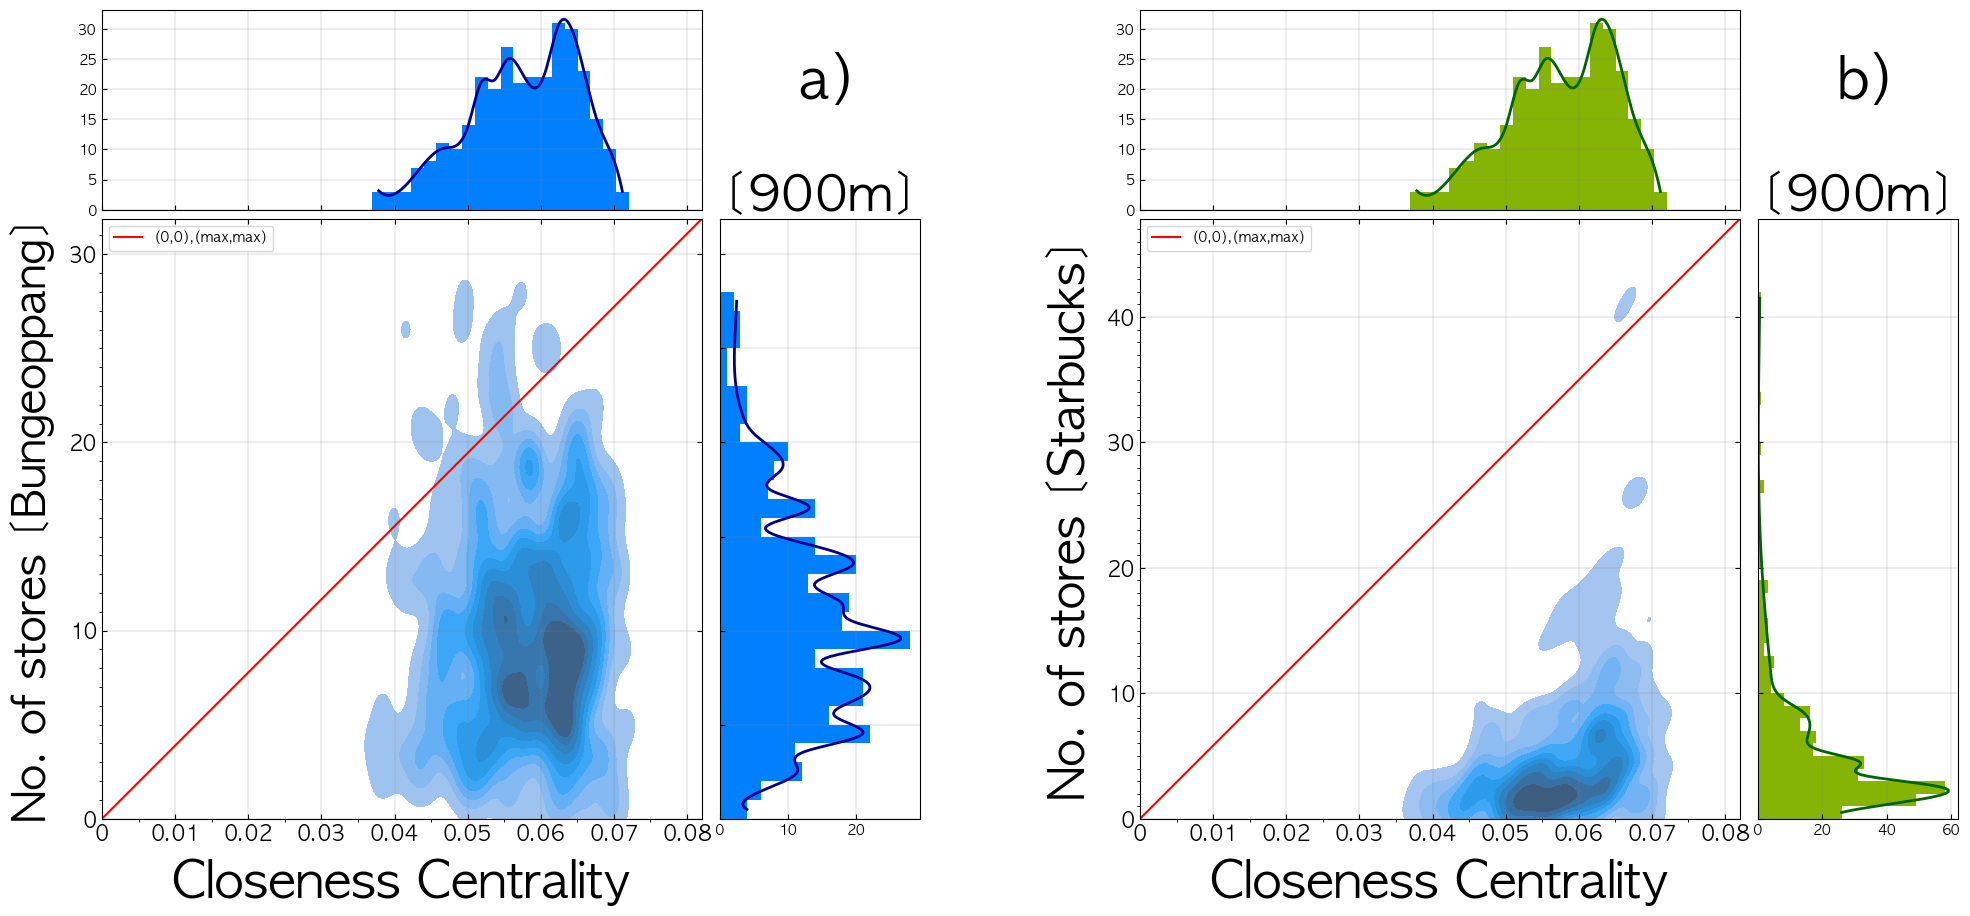

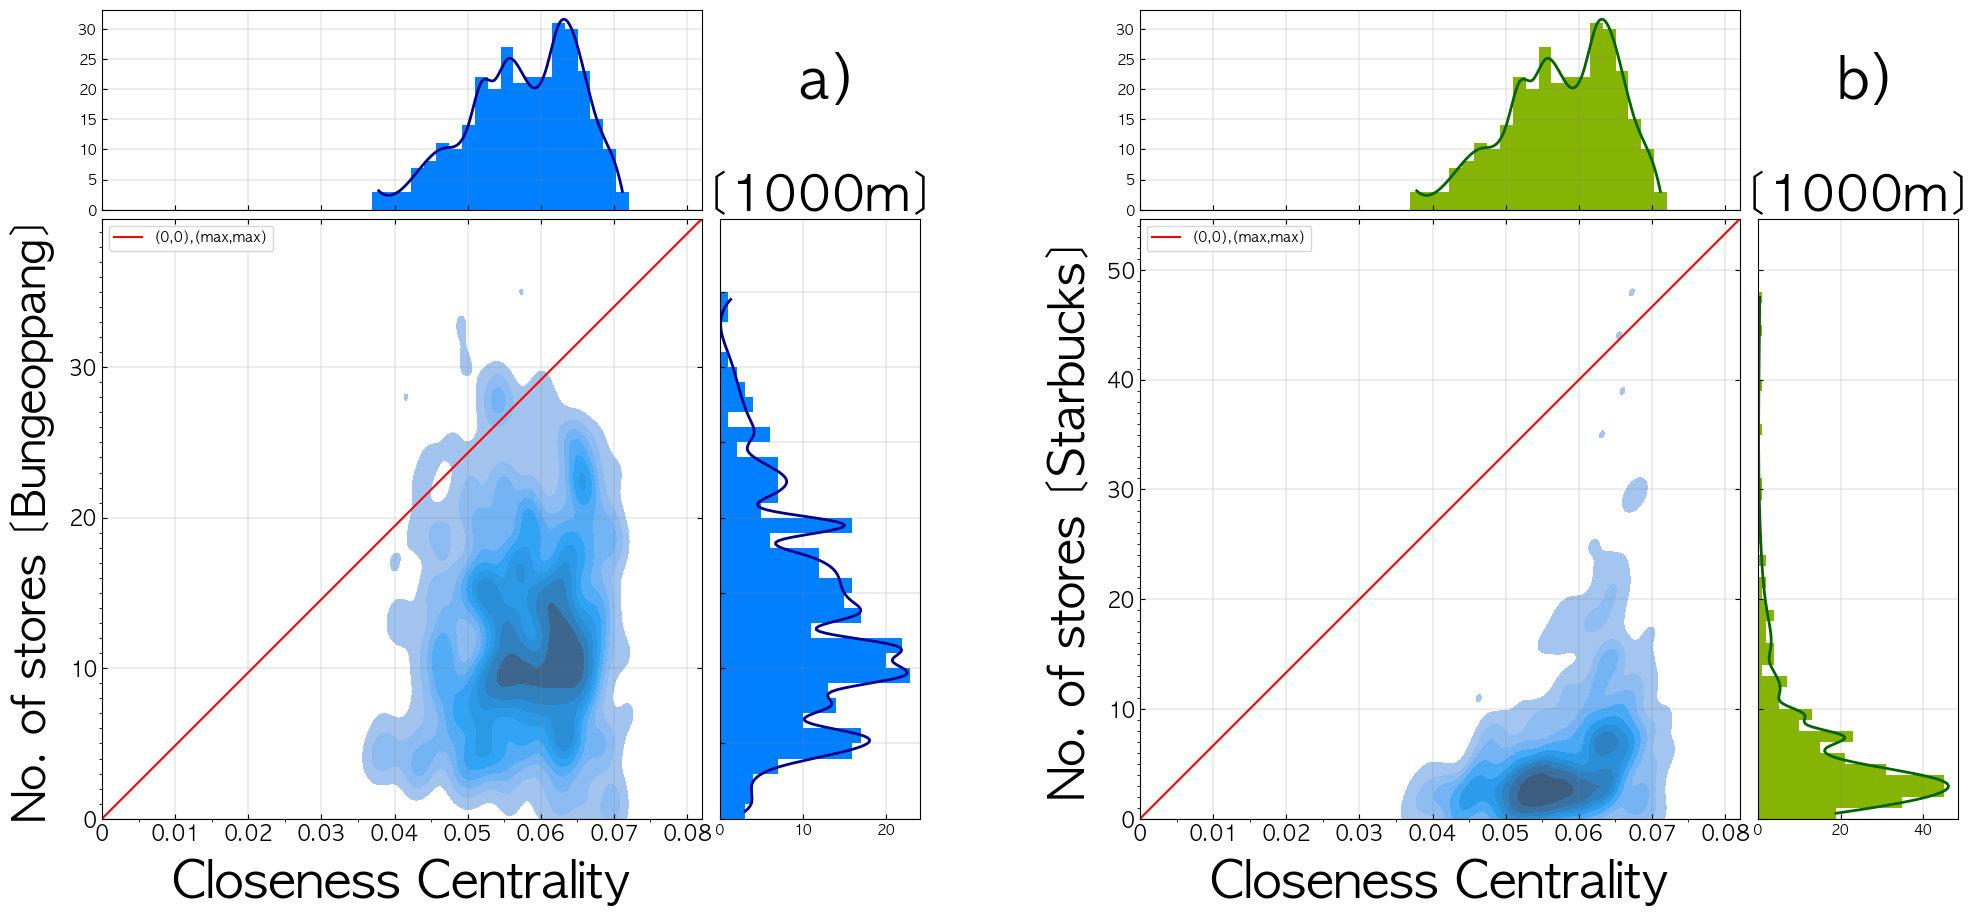

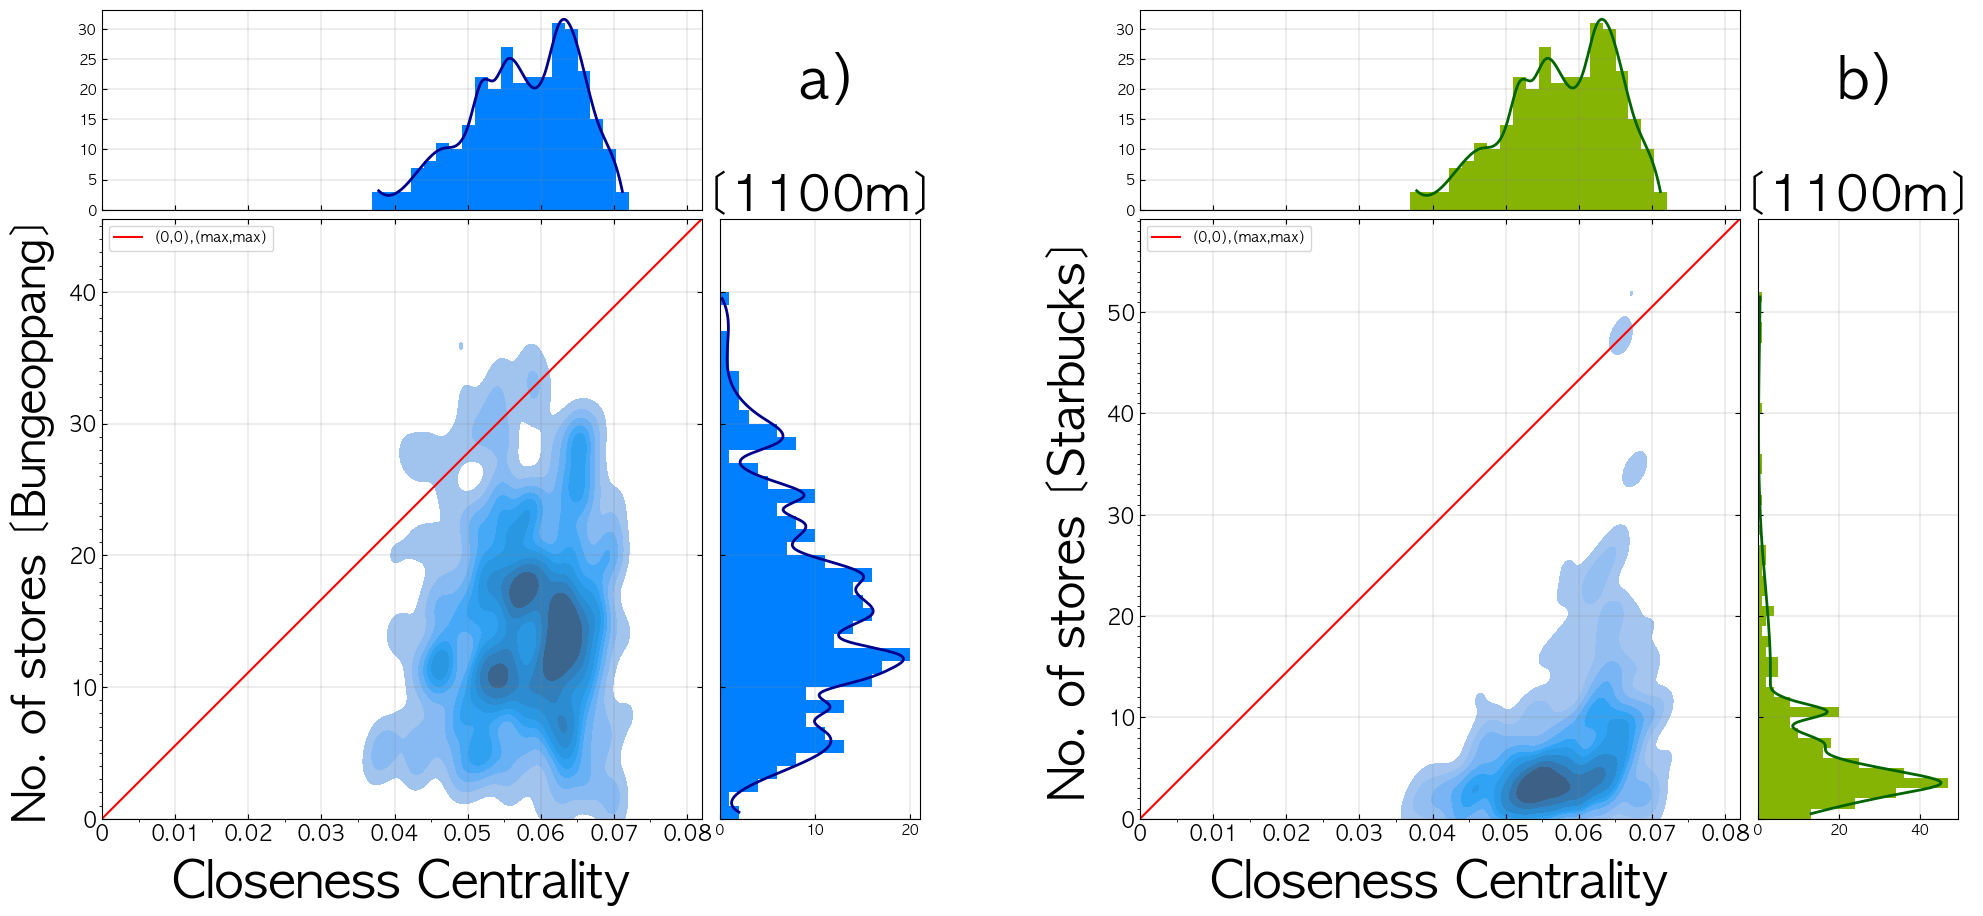

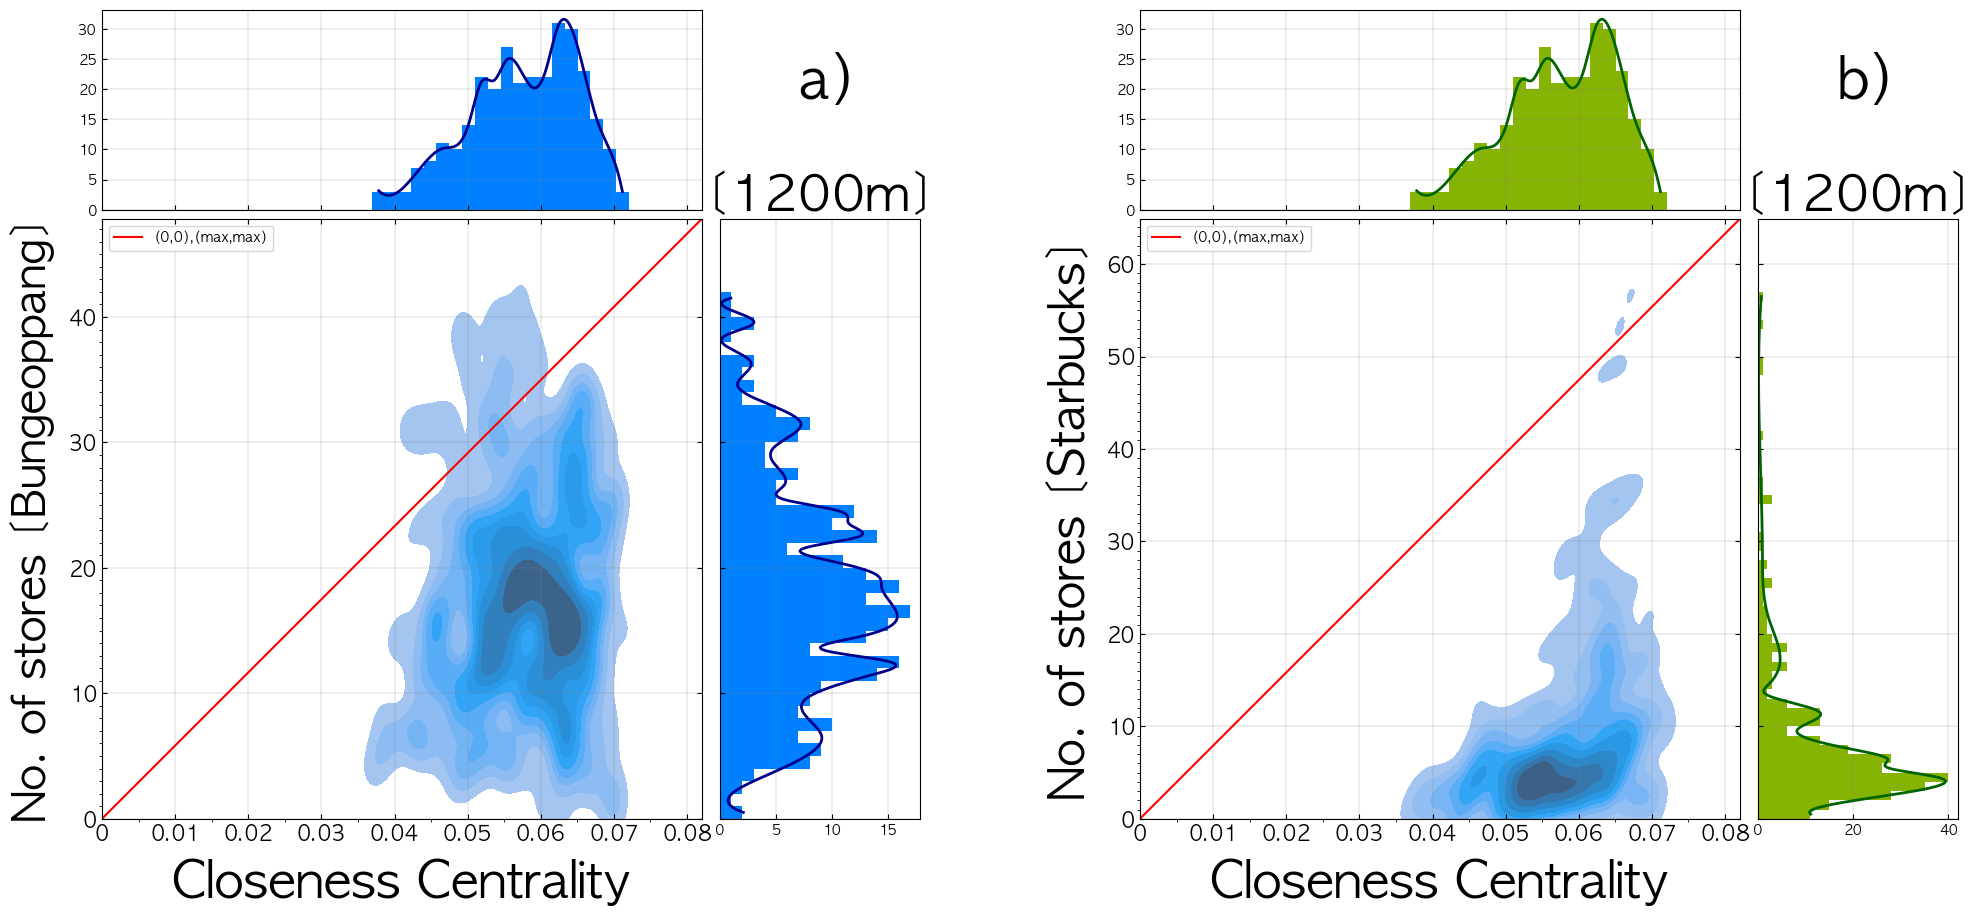

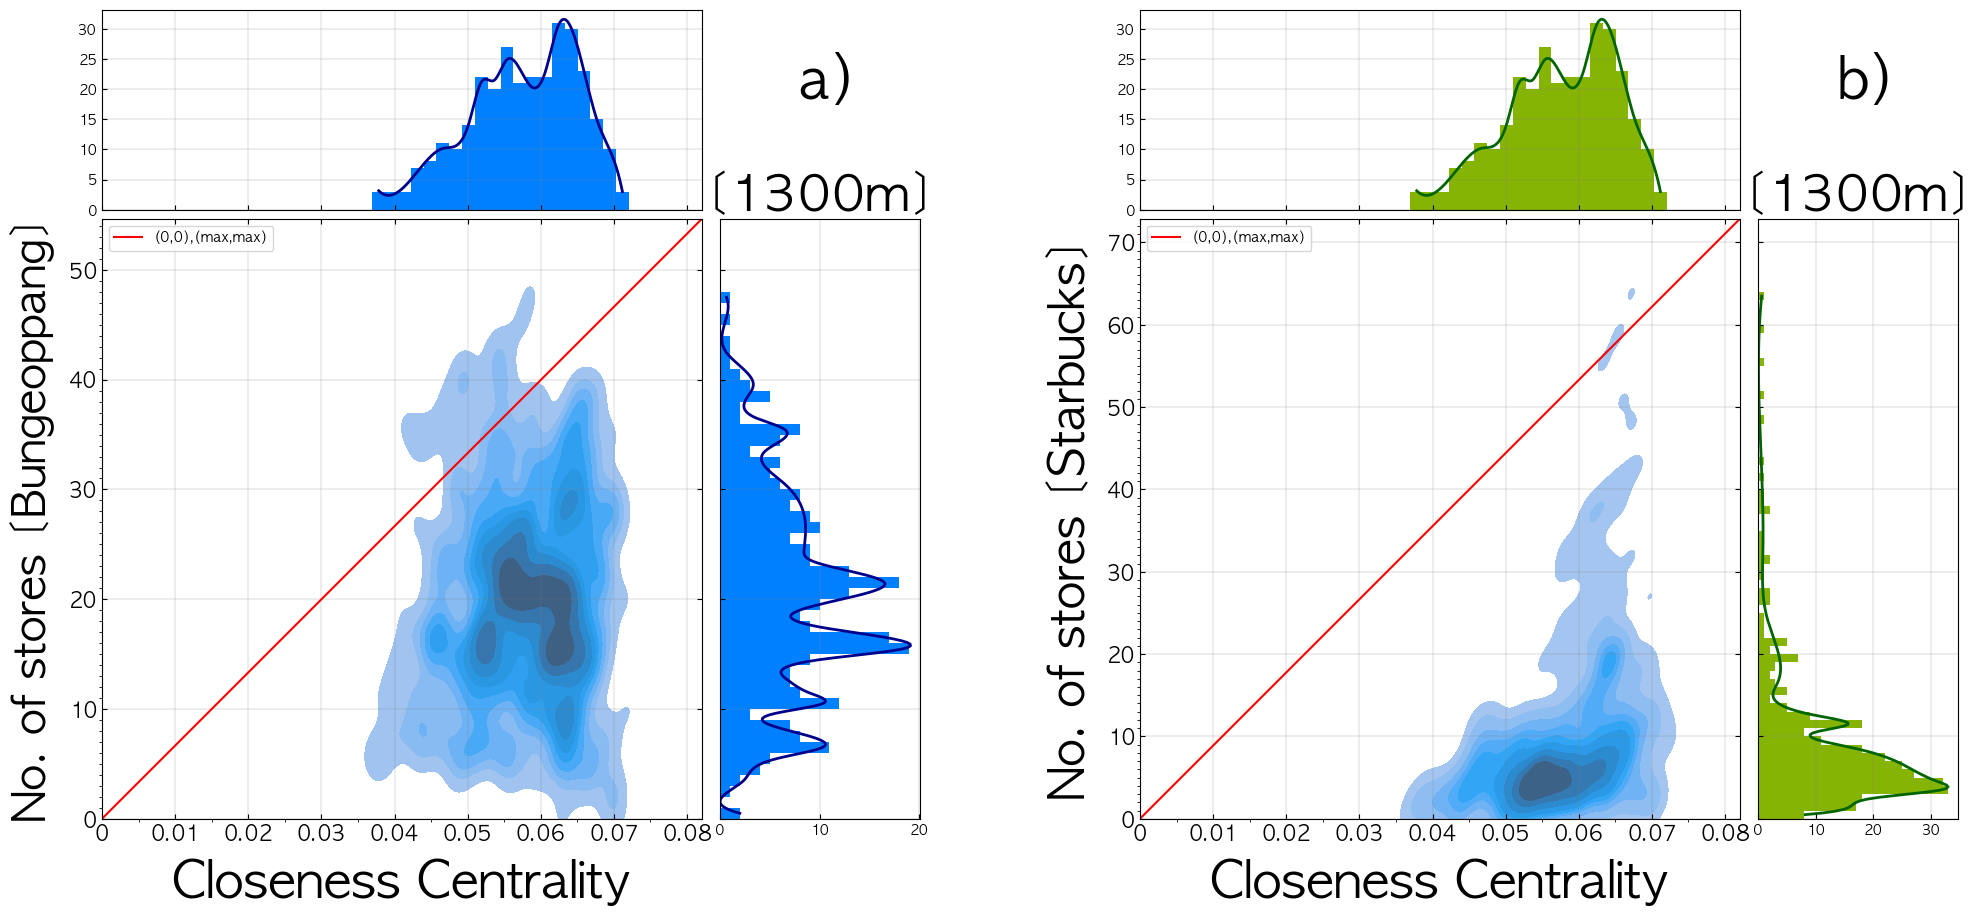

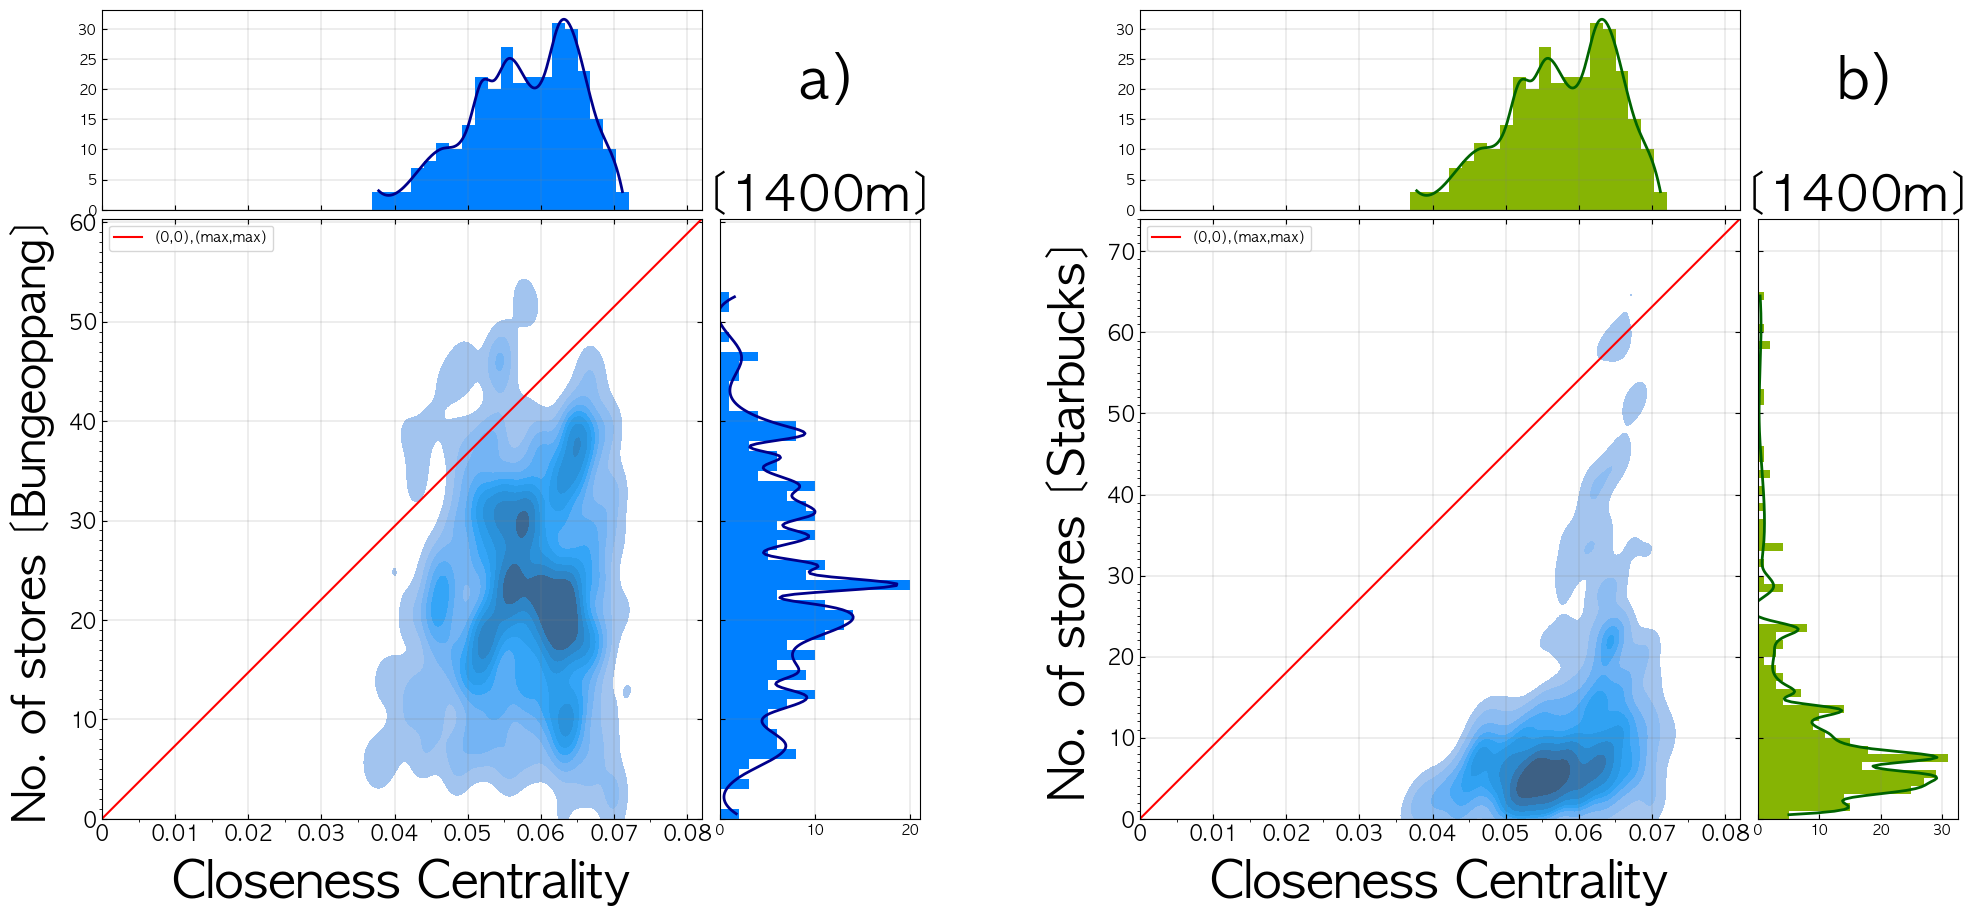

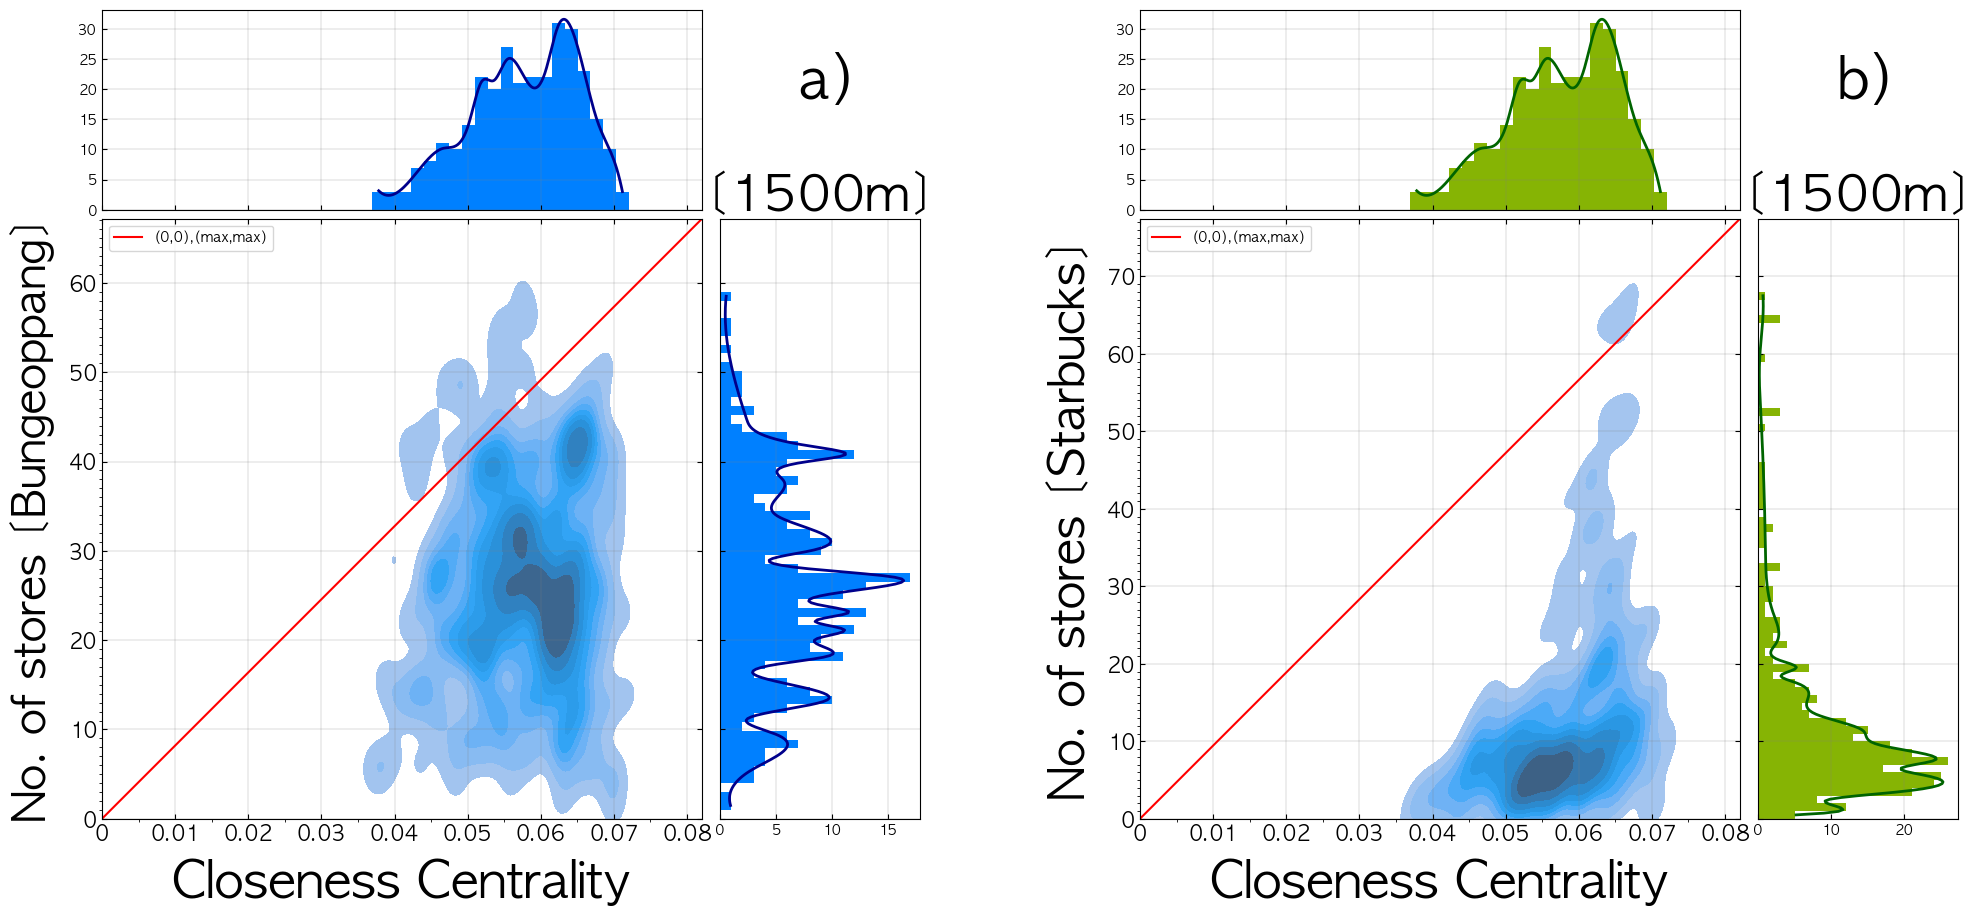

In [23]:
"""1)subplot(1,2,figsize())
1:1비율 jointplot tai vs Starbucks 비교 png (1500m)

2)JSD tai vs Starbucks 비교 png 
"""

#! #!jointsplineplot을 위한 레이아웃
 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
import os
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
rc('font', family = 'AppleGothic') #실행환경이 Mac일 경우

# os.chdir(os.path.dirname(__file__))

# cent_df = pd.read_excel('/Volumes/YAHO_/006.일일 보관/INPUTS_update_0417/Bungeoppang_1500_2500_all_count_tai.xlsx')
cent_df = pd.read_excel('/Volumes/YAHO_/용도별 코드_Input포함/20250205_서울시내 역(station_df, cent_df 통합).xlsx')
tai1 = 'Bungeoppang' #!tai에 맞게 설정해주자.. 
tai2 = 'Starbucks' #!tai에 맞게 설정해주자.. 
poly1_color = 'darkblue' #!그래프 색도,,,
hist1_color = '#0080FF' #!색상표.ipynb참고하기..
poly2_color = 'darkgreen' #!그래프 색도,,,
hist2_color = '#86B404' #!색상표.ipynb참고하기..
# count_df = pd.read_excel(f'{tai}_all_count_tai.xlsx')
# count1_df = pd.read_excel('/Volumes/YAHO_/006.일일 보관/INPUTS_update_0417/붕어빵_1500_2500_all_count_tai.xlsx')
count1_df = pd.read_excel('/Volumes/YAHO_/006.일일 보관/INPUTS_update_0417/20250203_Count.xlsx')
count2_df = pd.read_excel('/Volumes/YAHO_/006.일일 보관/INPUTS_update_0417/스타벅스_all_count_tai.xlsx')
# count2_df = pd.read_excel('/Volumes/YAHO_/006.일일 보관/INPUTS_update_0417/스타벅스_1500_2500_all_count_tai.xlsx')

def Scubic_spline(data, data_column, count_df, count_column, set_bins = False):
    x = data[data_column]
    max_x = count_df[count_column].max()
    counts, bins = np.histogram(x, bins=max_x, density=False)
    if set_bins != False:
        counts, bins = np.histogram(x, bins=set_bins, density=False)
    else :
        bins = bins
    bin_centers = (bins[:-1] + bins[1:]) / 2
    # cs = interpolate.CubicSpline(bin_centers, counts) # 정확한 cubic_spline 계산
    cs = UnivariateSpline(bin_centers, counts) # smoothing 정도를 계산 가능
    x_interp = np.linspace(bin_centers.min(), bin_centers.max(), 300)
    y_interp = cs(x_interp)
    return x_interp, y_interp

def Joint_SplinePlot_FixedCentralityBins(cent_df, count1_df,count2_df, column = 1000,set_bins = False,\
    x_zero = 1, y_zero = 1, save = False, s = 100):    
    

    x = cent_df["Closeness Centrality"]
    y1 = count1_df[column]
    y2 = count2_df[column]
    # print(np.std(x))
    # print(np.std(y1))
    # sigma_x = np.std(x)
    sigma_y1 = np.std(y1)
    sigma_y2 = np.std(y2)
    h_y1 = 1.06 * sigma_y1 * len(y1) ** (-1/5) #! kde의 bandwidth 설정
    h_y2 = 1.06 * sigma_y2 * len(y2) ** (-1/5) #! kde의 bandwidth 설정
    print(f'{column}m || bandwidth_y1: {h_y1}, bandwidth_y2: {h_y2}') #! kde의 bandwidth 설정
    # bandwidth = ((h_y1+ h_y2)/2) #! kde의 bandwidth 설정
    bandwidth = 0.5 #500m기준값으로 통일
    #Axes 크기 설정
    left, width = 0.055, 0.3
    bottom, height = 0.1, 0.6
    sub_height = 0.2
    sub_width = 0.1
    spacing = 0.009
    
    rect_main1 = [left, bottom, width, height] ## 산포도, 2kde가 그려질 Main Axes 
    rect_histx1 = [left, bottom + height + spacing, width, sub_height] ## x축 히스토그램이 그려질 Axes
    rect_histy1 = [width + spacing + left, bottom, sub_width, height] ## y축 히스토그램이 그려질 Axes
    rect_main2 = [left+ width + 0.11+ sub_width +spacing, bottom, width, height] ## 산포도, 2kde가 그려질 Main2 Axes 
    rect_histx2 = [left+ width +0.11 + sub_width +spacing, bottom + height + spacing, width, sub_height] ## x2축 히스토그램이 그려질 Axes
    rect_histy2 = [left+ width +0.11 + sub_width +spacing+ width+ spacing, bottom, sub_width, height] ## y2축 히스토그램이 그려질 Axes
    
    fig = plt.figure(figsize=(20, 10)) #3:2비율
    fig.set_facecolor('white')
    
    #! 폰트 크기(제목과 축 이름은 전부 굵게)
    title_font = {
    'fontsize': 36,
    'fontweight': 'bold'
    }
    label_font = {
    'fontsize' : 25
    ,'fontweight': 'bold'
    
    }
    #그리드 설정
    ## 3개 Axes 생성, axes 설정
    ax_main1 = plt.axes(rect_main1)
    ax_main2 = plt.axes(rect_main2)
    # ax_main.set_xlim((0.02, x.max()+0.01))
    # ax_main.set_ylim((0.0, y.max()+4.99))
    ax_main1.tick_params(direction='in', top=True, right=True, labelsize = 15) ## 눈금은 Axes 안쪽으로 설정
    ax_main2.tick_params(direction='in', top=True, right=True, labelsize = 15) ## 눈금은 Axes 안쪽으로 설정
    #! sub1
    ax_histx1 = plt.axes(rect_histx1)
    ax_histx1.tick_params(direction='in', labelbottom=False)
    ax_histy1 = plt.axes(rect_histy1)
    ax_histy1.tick_params(direction='in', labelleft=False)
    ax_main1.grid(True, axis='both', which = 'major', color='gray', linestyle='-', linewidth=0.2 )    
    ax_histx1.grid(True, axis='both', which = 'major', color='gray', linestyle='-', linewidth=0.2 )    
    ax_histy1.grid(True, axis='both', which = 'major', color='gray', linestyle='-', linewidth=0.2 )    
    #! sub2
    ax_histx2 = plt.axes(rect_histx2)
    ax_histx2.tick_params(direction='in', labelbottom=False)
    ax_histy2 = plt.axes(rect_histy2)
    ax_histy2.tick_params(direction='in', labelleft=False)
    ax_main2.grid(True, axis='both', which = 'major', color='gray', linestyle='-', linewidth=0.2 )    
    ax_histx2.grid(True, axis='both', which = 'major', color='gray', linestyle='-', linewidth=0.2 )    
    ax_histy2.grid(True, axis='both', which = 'major', color='gray', linestyle='-', linewidth=0.2 ) 
    
    slope1 = y1.max()/x.max()
    slope2 = y2.max()/x.max()
    x_range = np.arange(0, 1, 0.001)
    y1_range = slope1*x_range
    y2_range = slope2*x_range
    ax_main1.plot(x_range, y1_range, label = '(0,0),(max,max)', color = 'red') ##! 기준선 생성
    ax_main1.set_xlim((0.02, x.max()+0.01))
    ax_main1.set_ylim((0.0, slope1*(x.max()+0.01)))
    ax_main1.yaxis.set_major_locator(MultipleLocator(10))
    ax_main1.yaxis.set_minor_locator(MultipleLocator(1))
    ax_main2.plot(x_range, y2_range, label = '(0,0),(max,max)', color = 'red') ##! 기준선 생성
    ax_main2.set_xlim((0.02, x.max()+0.01))
    ax_main2.set_ylim((0.0, slope2*(x.max()+0.01)))
    ax_main2.yaxis.set_major_locator(MultipleLocator(10))
    ax_main2.yaxis.set_minor_locator(MultipleLocator(1))
    if x_zero == 0: #True일 경우 0부터 표시되도록
        ax_main1.set_xticks(np.arange(0,round(x.max()+0.01,2), 0.005)) 
        ax_main1.xaxis.set_major_locator(MultipleLocator(0.01))
        ax_main1.xaxis.set_minor_locator(MultipleLocator(0.005))
        ax_main2.set_xticks(np.arange(0,round(x.max()+0.01,2), 0.005)) 
        ax_main2.xaxis.set_major_locator(MultipleLocator(0.01))
        ax_main2.xaxis.set_minor_locator(MultipleLocator(0.005))
        
    else:
        ax_main1.set_xticks(np.arange(0.02,round(x.max()+0.01,2), 0.005)) 
        ax_main2.set_xticks(np.arange(0.02,round(x.max()+0.01,2), 0.005)) 

    current_values = ax_main1.get_xticks()
    ax_main1.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거
    current_values = ax_main2.get_xticks()
    ax_main2.set_xticklabels(['{:g}'.format(x) for x in current_values]) # .nf로 소수점 자리수 설정 가능 g는 끝0 제거거
    
    # 각 Axes에 히스토그램 그리기
    #!sub1
    bins = y1.max()
    x_counts, _ = np.histogram(x, bins=20)
    y_counts, _ = np.histogram(y1, bins=bins)
    histx_x_interp, histx_y1_interp = Scubic_spline(cent_df,'Closeness Centrality',count1_df, column , set_bins = set_bins) #x축 spline 계산(bins는 변수입력, 안 넣으면 count_df따라감)
    ax_histx1.plot(histx_x_interp,histx_y1_interp,  color=poly1_color, lw=2, label='Cubic Spline') #y축 spline 그리기 (centrality)
    ax_histx1.hist(x, bins= 20, density= False,color=hist1_color) ## x축 히스토그램
    histy_x_interp, histy_y1_interp = Scubic_spline(count1_df,column, count1_df, column) #y축 spline 계산
    ax_histy1.plot(histy_y1_interp,histy_x_interp,  color=poly1_color, lw=2, label='Cubic Spline') #y축 spline 그리기#0080FF#FFFF00#86B404
    ax_histy1.hist(y1, bins= bins, orientation='horizontal',color = hist1_color) ## y축 히스토그램

    sns.kdeplot(ax = ax_main1 ,bw_adjust= bandwidth, fill= True, \
        x = x, y = y1) ## 2D kde 생성
    #!sub2
    bins = y2.max()
    x_counts, _ = np.histogram(x, bins=20)
    y2_counts, _ = np.histogram(y2, bins=bins)
    histx_x_interp, histx_y2_interp = Scubic_spline(cent_df,'Closeness Centrality',count2_df, column , set_bins = set_bins) #x축 spline 계산(bins는 변수입력, 안 넣으면 count_df따라감)
    ax_histx2.plot(histx_x_interp,histx_y2_interp,  color=poly2_color, lw=2, label='Cubic Spline') #y축 spline 그리기 (centrality)
    ax_histx2.hist(x, bins= 20, density= False,color=hist2_color) ## x축 히스토그램
    histy_x_interp, histy_y2_interp = Scubic_spline(count2_df,column, count2_df, column) #y축 spline 계산
    ax_histy2.plot(histy_y2_interp,histy_x_interp,  color=poly2_color, lw=2, label='Cubic Spline') #y축 spline 그리기#0080FF#FFFF00#86B404
    ax_histy2.hist(y2, bins= bins, orientation='horizontal',color = hist2_color) ## y축 히스토그램

    sns.kdeplot(ax = ax_main2 , bw_adjust= bandwidth, fill= True, \
        x = x, y = y2)

    #!sub1
    plt.text(-4.8, 1.2, f'a)', transform=plt.gca().transAxes, fontsize=40,fontweight = 'bold')
    plt.text(.40, 1.2, f'b)', transform=plt.gca().transAxes, fontsize=40,fontweight = 'bold')
    # plt.text(1.01, .4, f'b)', transform=plt.gca().transAxes, fontsize=24,fontweight = 'bold')
    ax_histx1.set_ylim(0, None)
    ax_histx1.set_xlim(ax_main1.get_xlim()) 
    ax_histy1.set_xlim(0, None)
    ax_histy1.set_ylim(ax_main1.get_ylim())
    # plt.suptitle('[CC에 대한 지하철 역의 개수 분포]',x=0.28, y=0.89 , fontsize = 10)
    # plt.suptitle(f'[지하철 역에 대하여 {column}m 이내의 Starbucks 지점 분포]',x=0.28, y=0.89 , fontsize = 10)
    # ax_histx.set_title('[CC에 대한 지하철 역의 개수 분포]')
    # ax_histy.set_title(f'[지하철 역에 대하여 \n{column}m 이내의 {tai} 지점 분포]', fontdict=title_font)
    ax_histy1.set_title(f'[{column}m]', fontdict=title_font)
    ax_main1.set_xlabel('Closeness Centrality', loc = 'center',labelpad = 10 , fontsize = 36, fontweight = 1000) ## 산포도 x 라벨
    ax_main1.set_ylabel(f'No. of stores [{tai1}]' , labelpad = 10 , fontsize = 32, fontweight = 1000) ## 산포도 y 라벨
    ax_main1.legend(loc='upper left')
    # plt.title(f'[{column}]m ', loc = 'right' , fontdict= title_font)
    #!sub2
    ax_histx2.set_ylim(0, None)
    ax_histx2.set_xlim(ax_main2.get_xlim()) 
    ax_histy2.set_xlim(0, None)
    ax_histy2.set_ylim(ax_main2.get_ylim())
    # plt.suptitle('[CC에 대한 지하철 역의 개수 분포]',x=0.28, y=0.89 , fontsize = 10)
    # plt.suptitle(f'[지하철 역에 대하여 {column}m 이내의 Starbucks 지점 분포]',x=0.28, y=0.89 , fontsize = 10)
    # ax_histx.set_title('[CC에 대한 지하철 역의 개수 분포]')
    # ax_histy.set_title(f'[지하철 역에 대하여 \n{column}m 이내의 {tai} 지점 분포]', fontdict=title_font)
    ax_histy2.set_title(f'[{column}m]', fontdict=title_font )
    ax_main2.set_xlabel('Closeness Centrality', loc = 'center',labelpad = 10 , fontsize = 36, fontweight = 1000) ## 산포도 x 라벨
    ax_main2.set_ylabel(f'No. of stores [{tai2}]' , labelpad = 10 , fontsize = 34, fontweight = 1000) ## 산포도 y 라벨
    ax_main2.legend(loc='upper left')
    
    #저장여부
    if save == True: #저장을 할 지, 플롯을 보여줄 지 여부에 따라 실행. 기본값은 False
        plt.savefig(f'Figure S3 joint_{column}m_kde(bw={bandwidth:.2f})(x=0.00)_{date}.png')
    else:
        plt.show()
        
        
x = np.arange(300,1510,100)
for column in x:        
    Joint_SplinePlot_FixedCentralityBins(cent_df, count1_df=count1_df, count2_df = count2_df, column = column,set_bins = 20,\
    x_zero = 0, y_zero = 1, save = True, s = 100)

# Scatter CC/No. of stores

/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_36335/211937250.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize = 20, fontweight = 'bold')
/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_36335/211937250.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize = 20, fontweight = 'bold')
/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_36335/211937250.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f}'.format(y) for y in current_y_values])
/var/folders/9g/tzvf05595fz78tgcgzv059580000gs/T/ipykernel_36335/211937250.py:85: UserWarning: set_ticklabels() should only be used with a fixed 

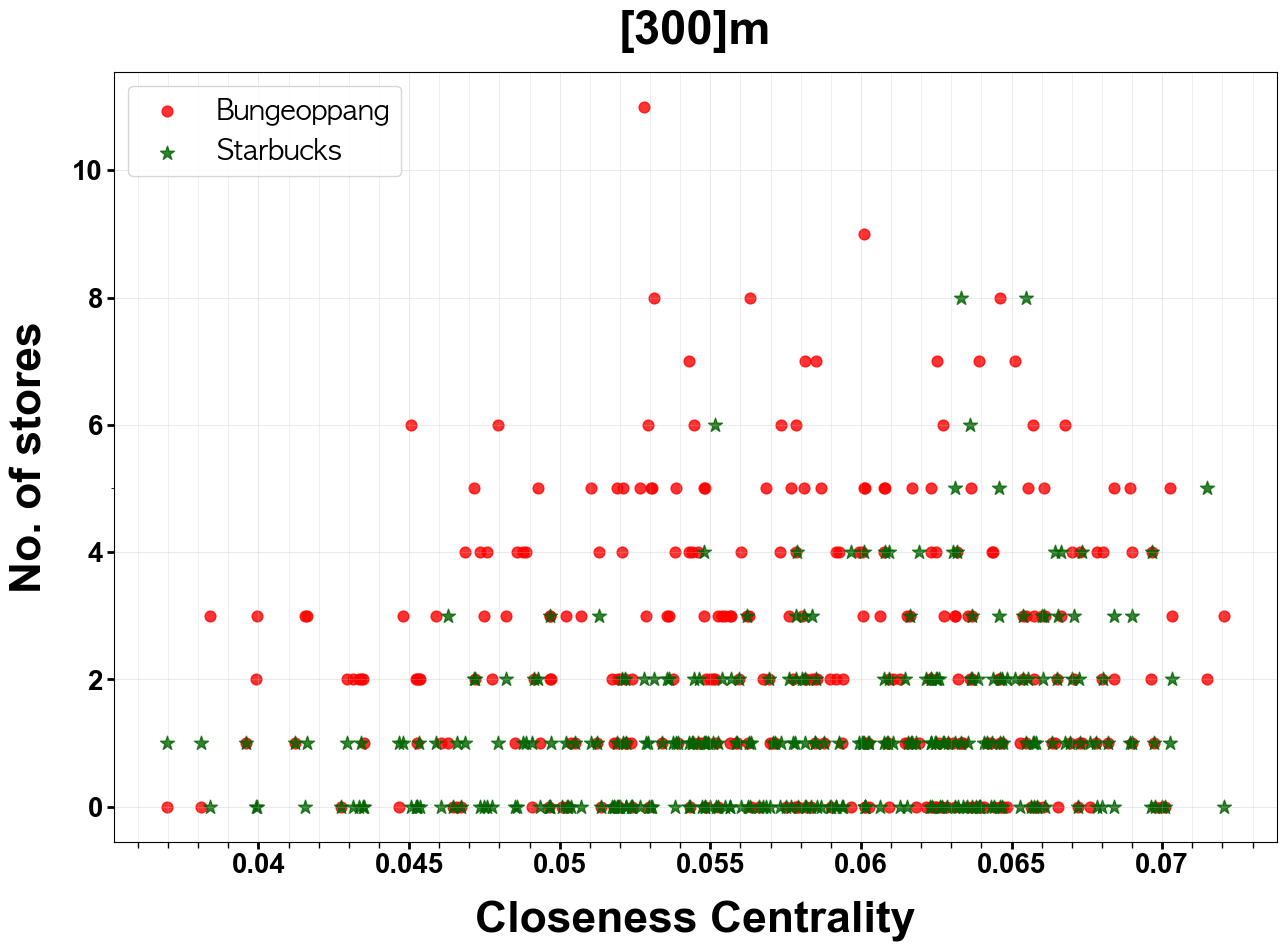

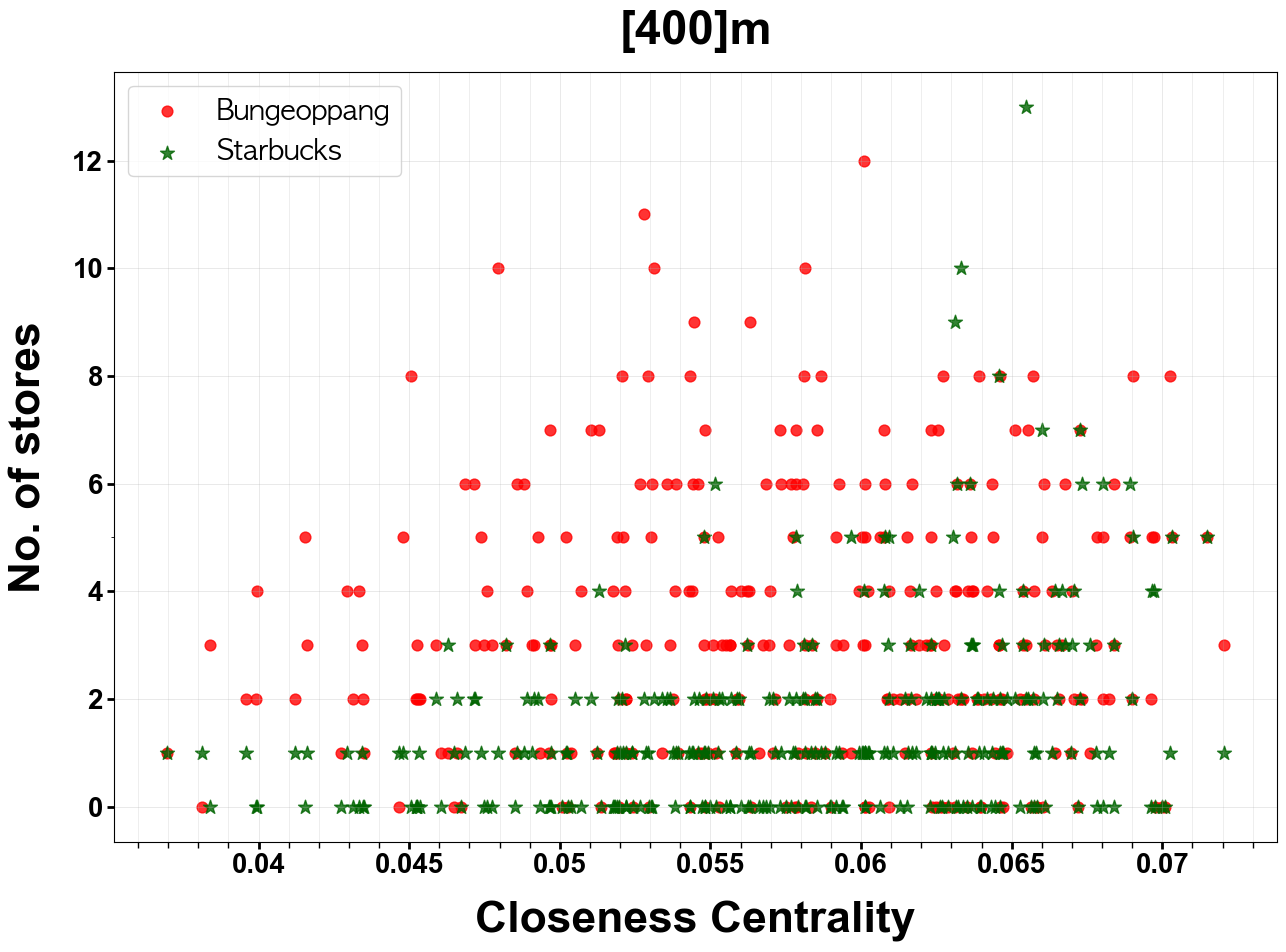

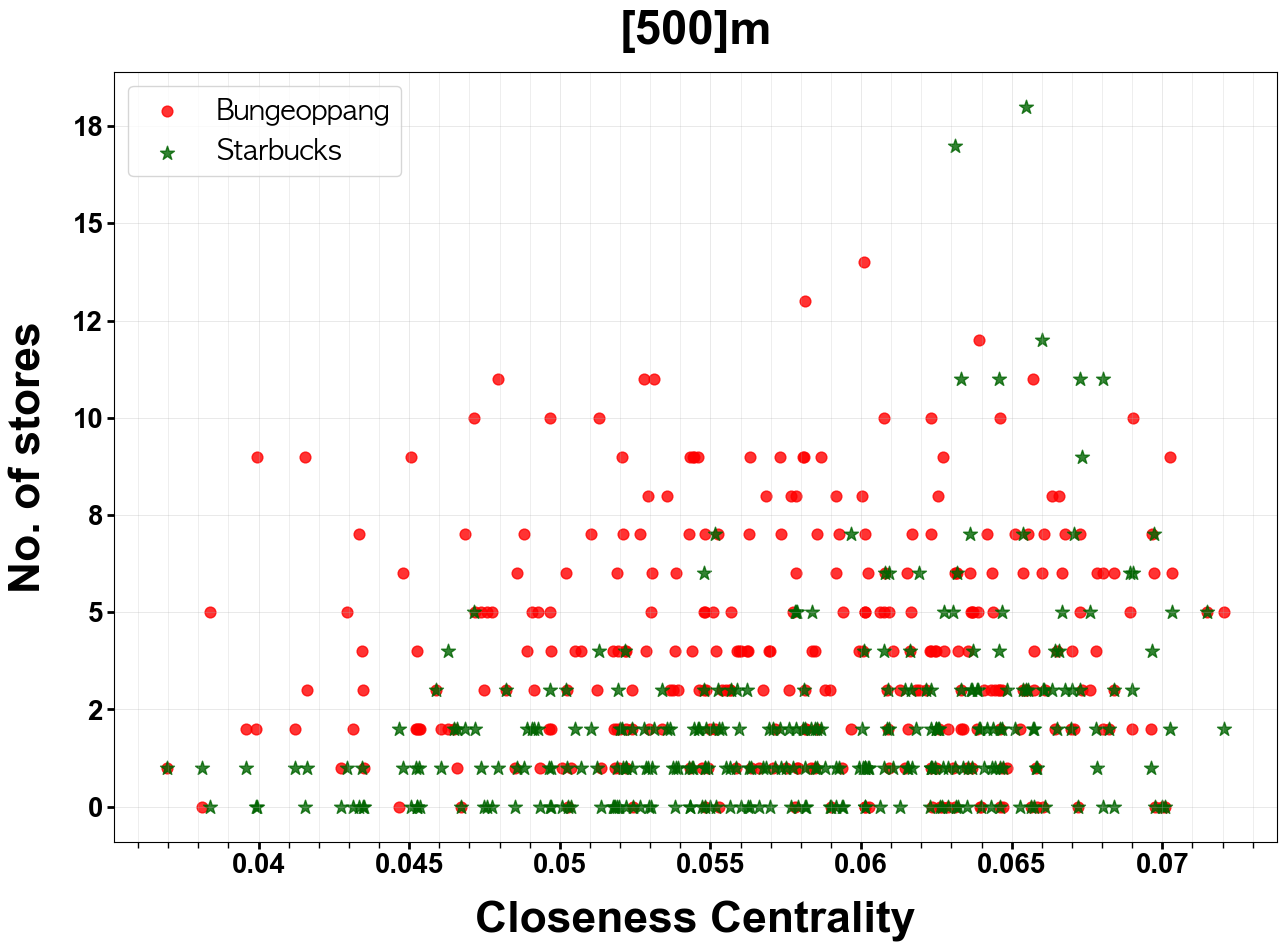

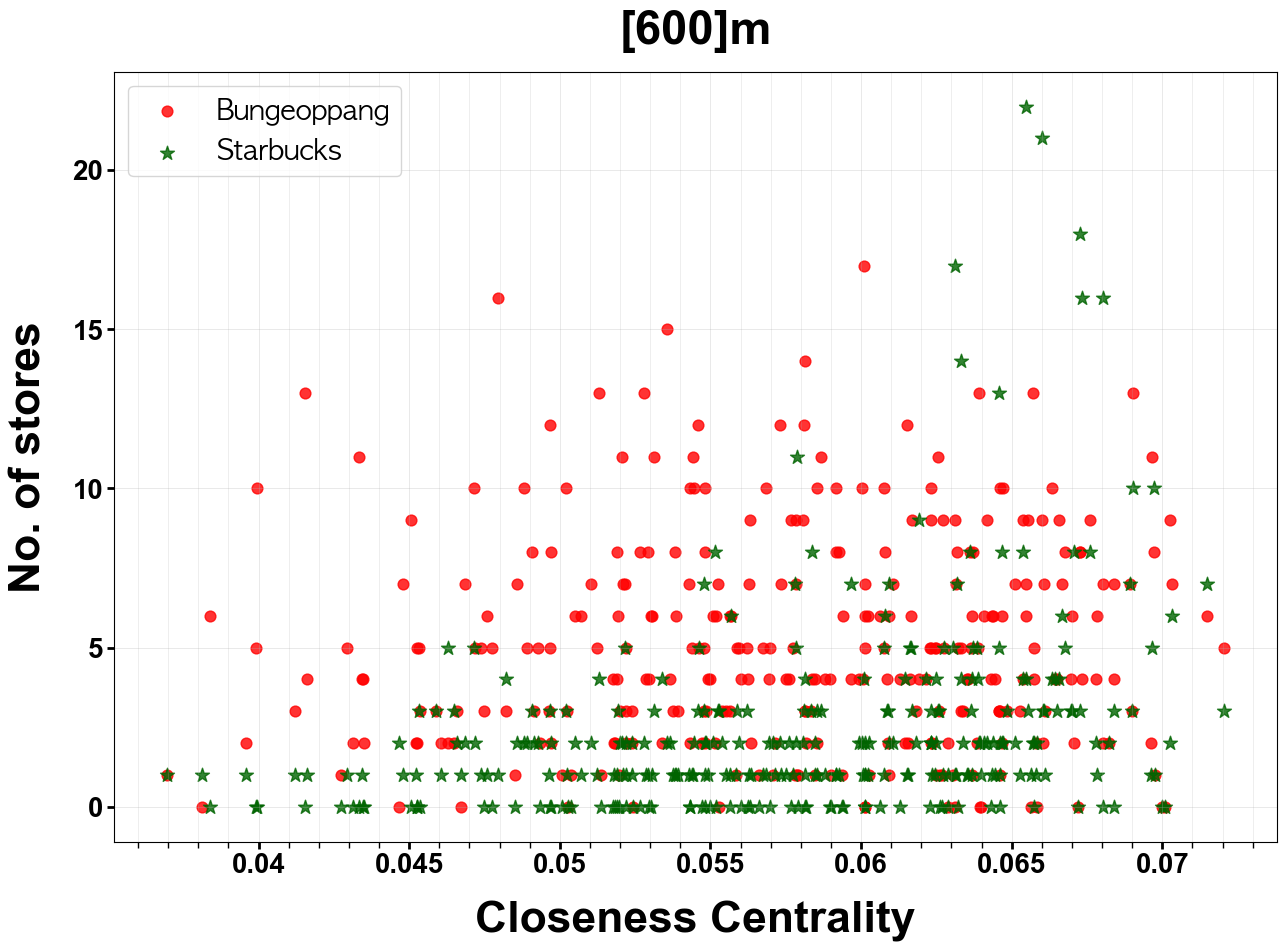

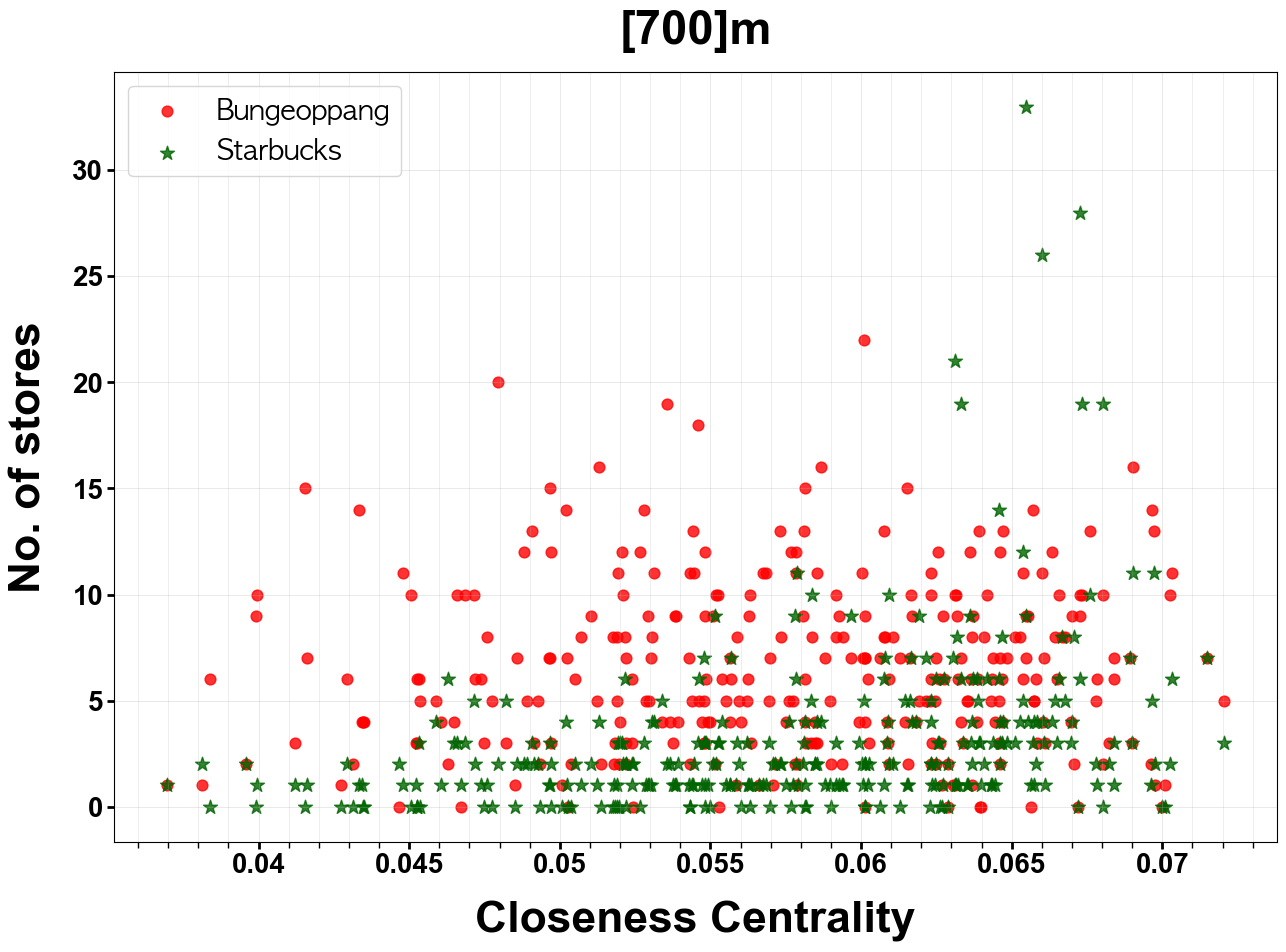

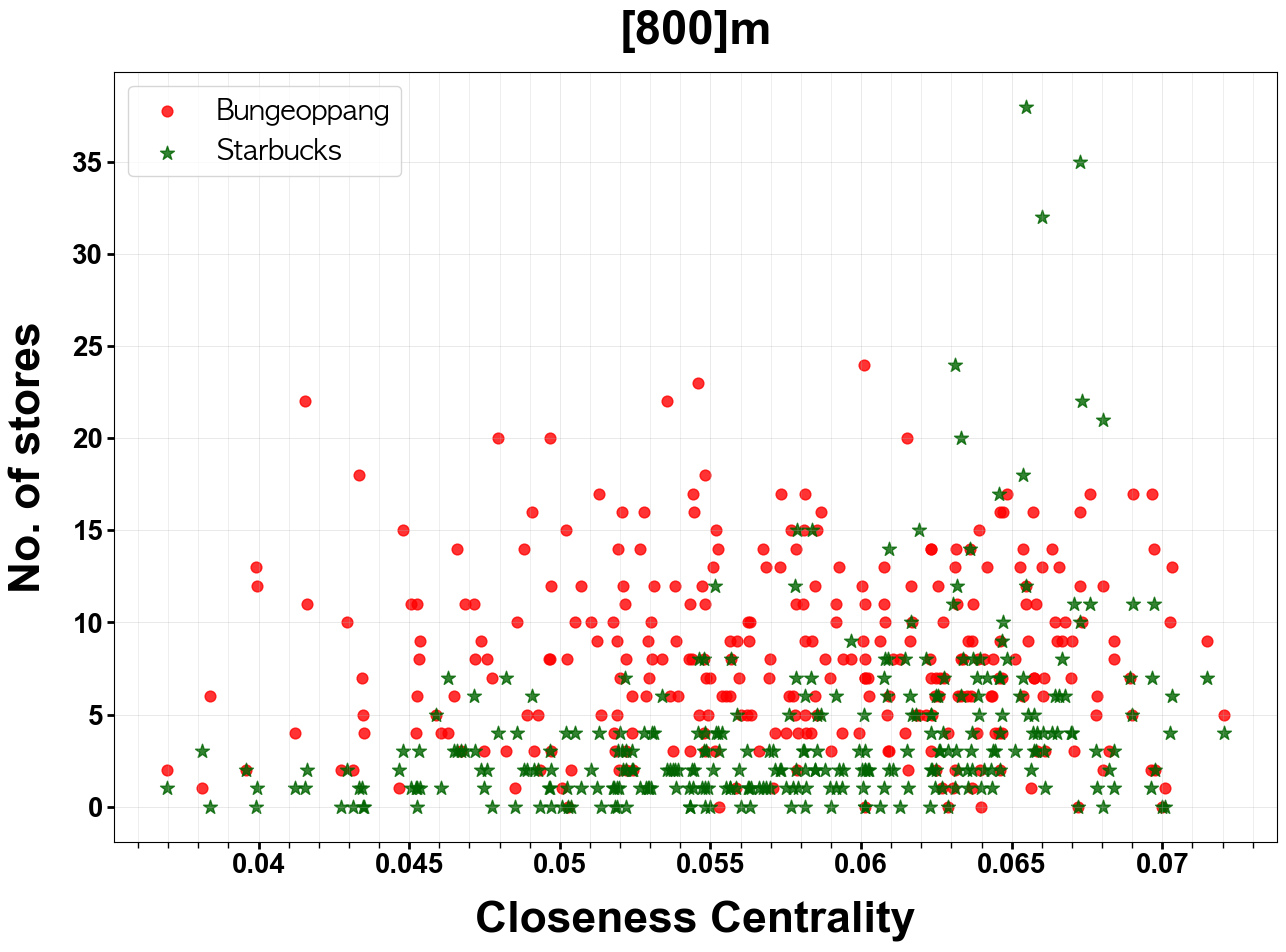

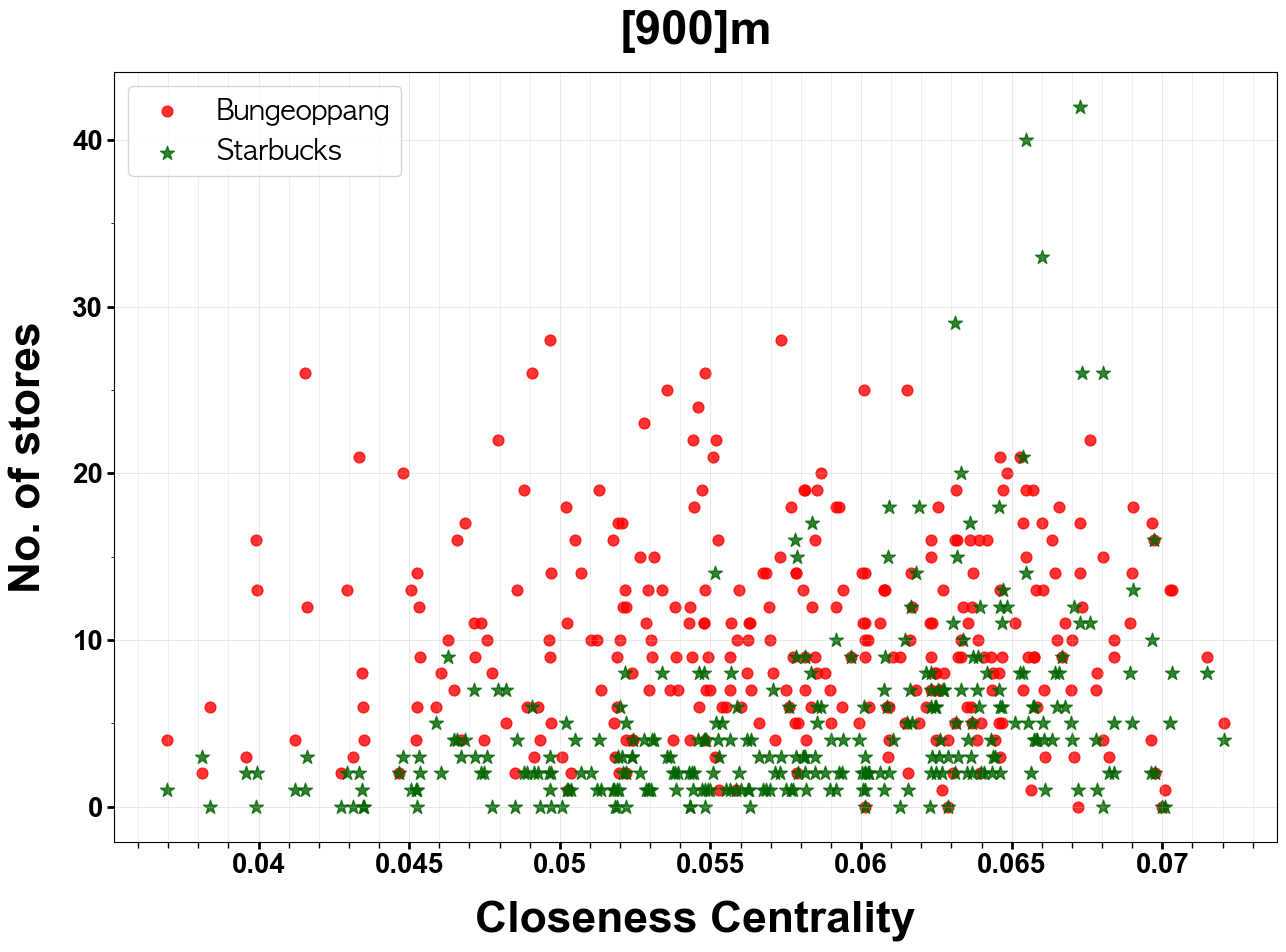

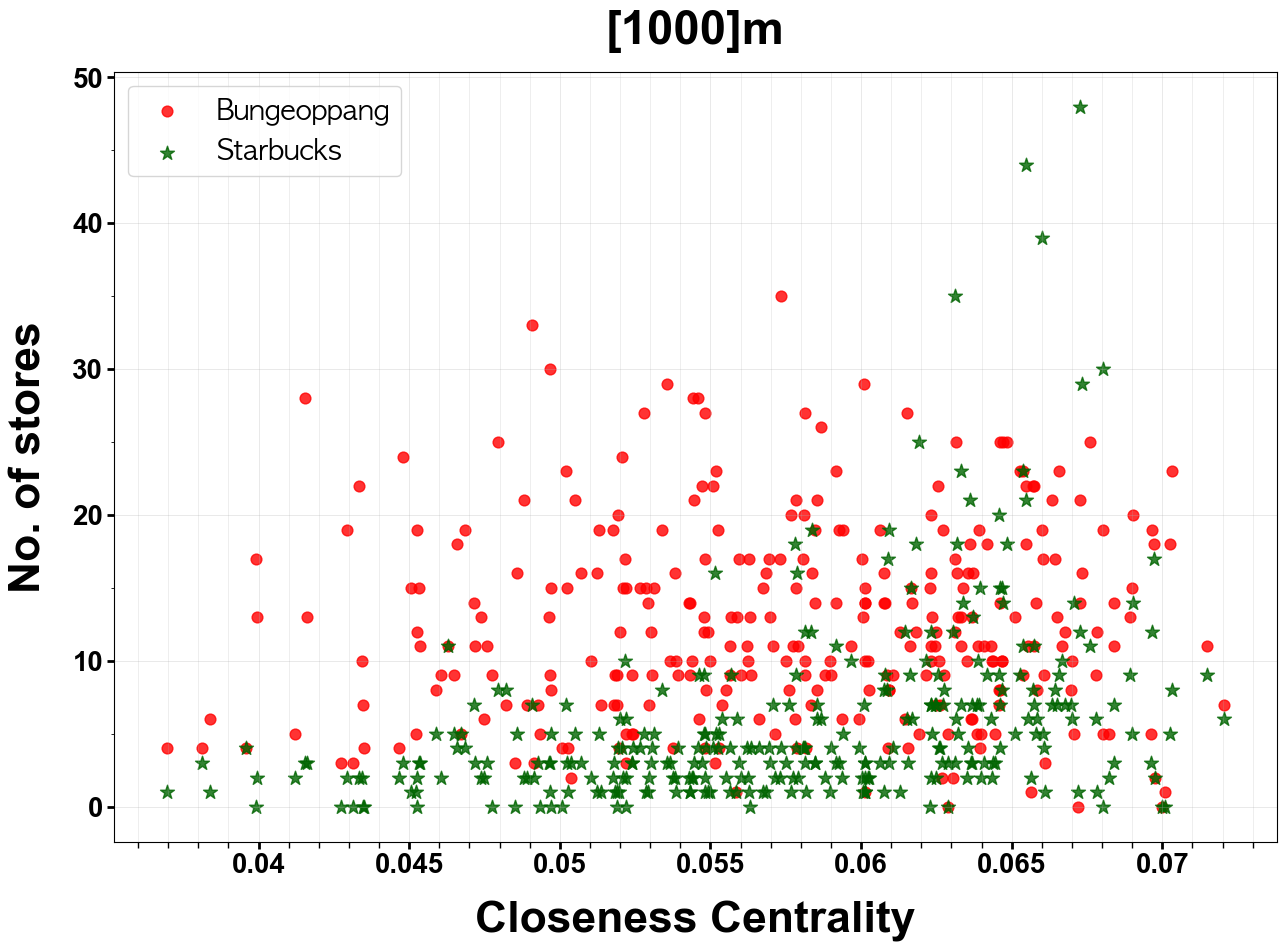

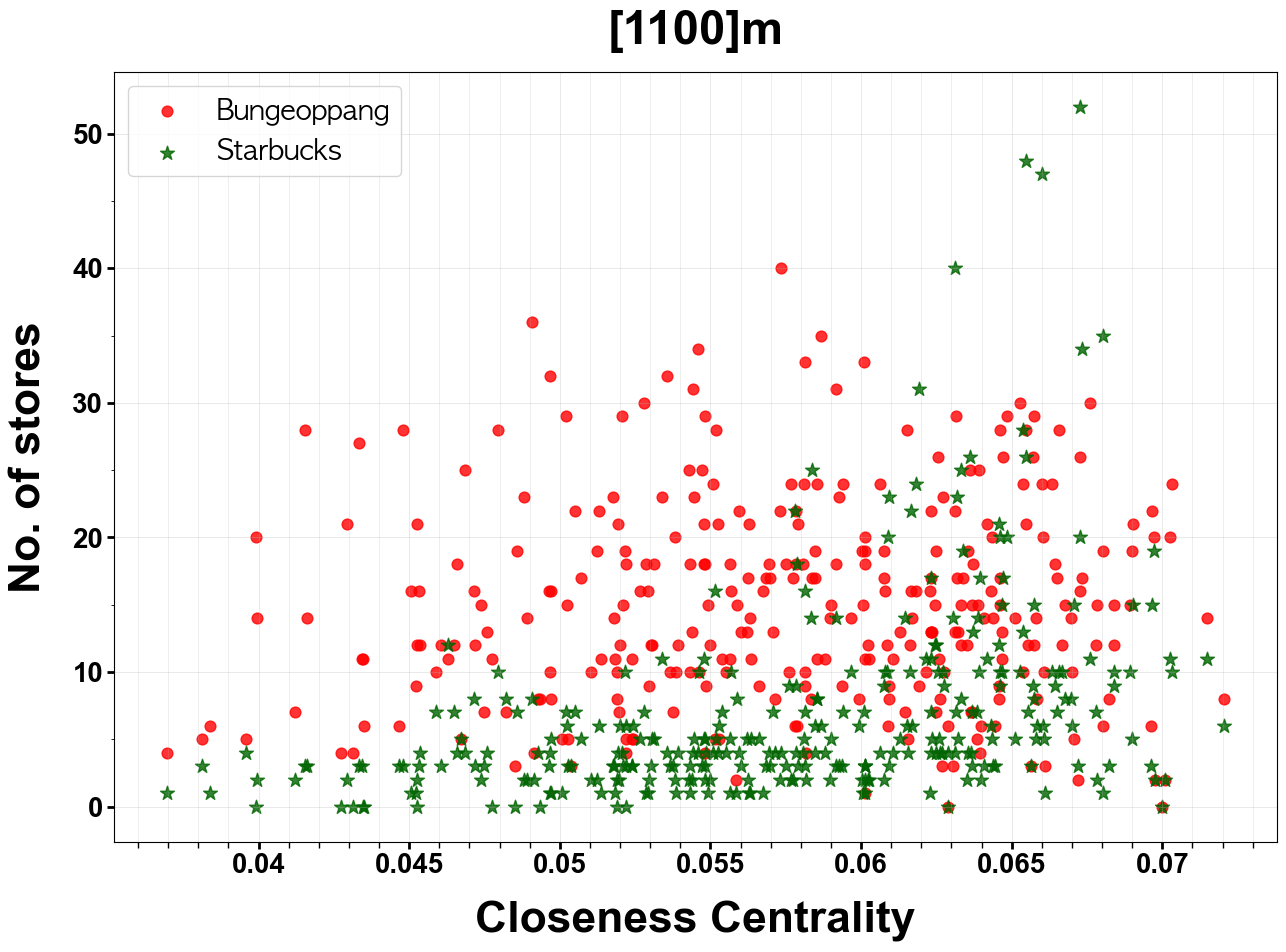

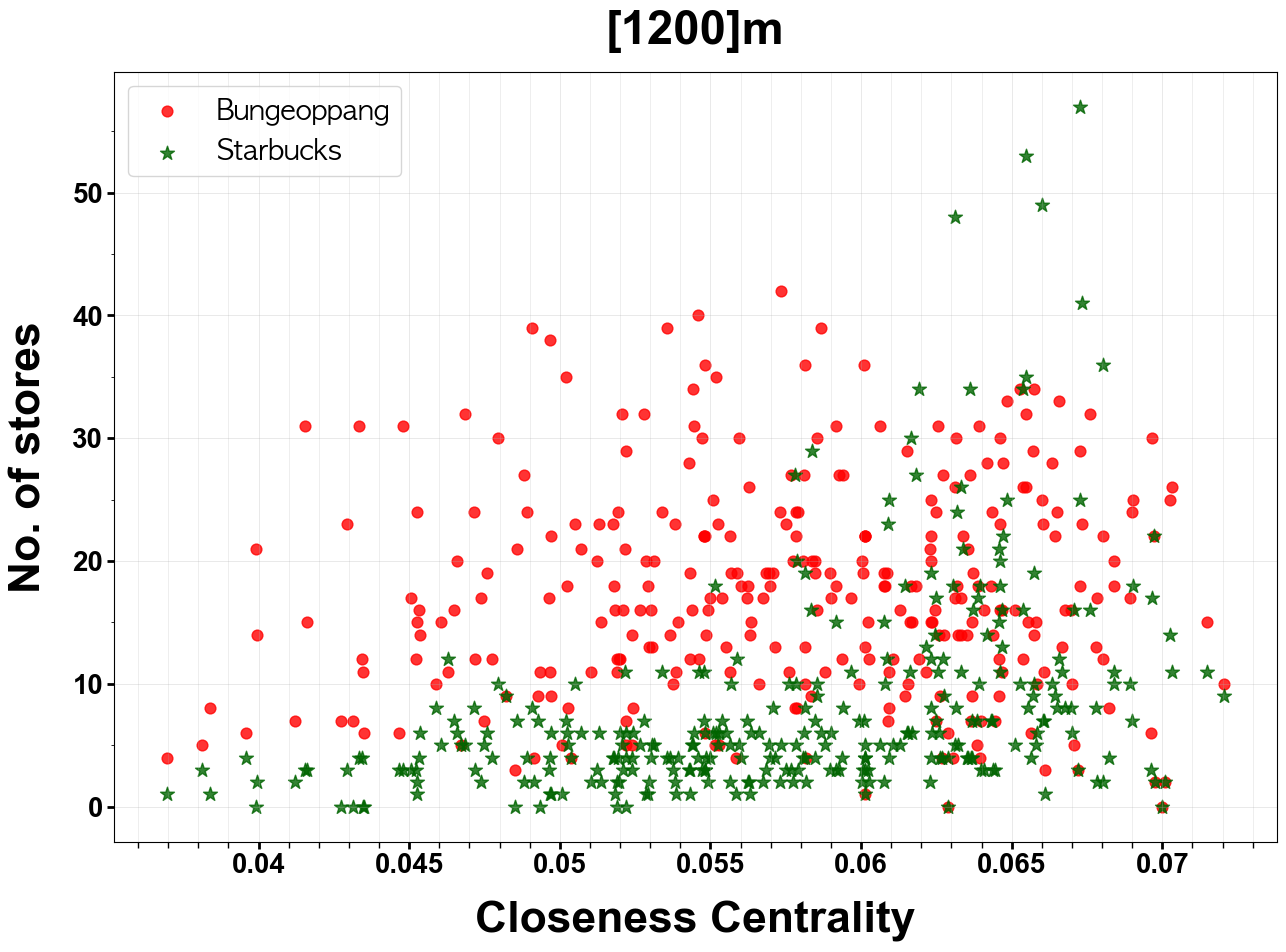

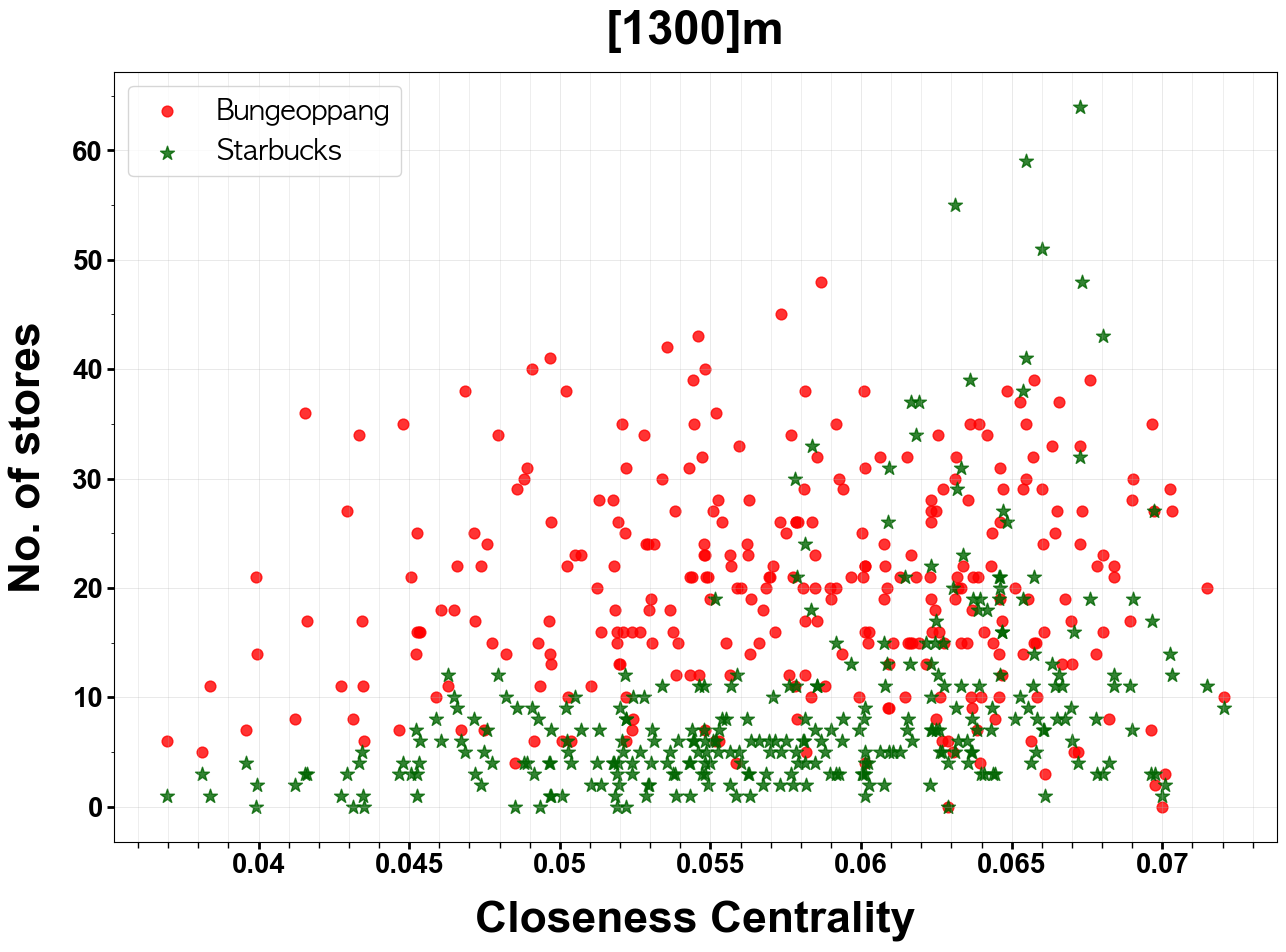

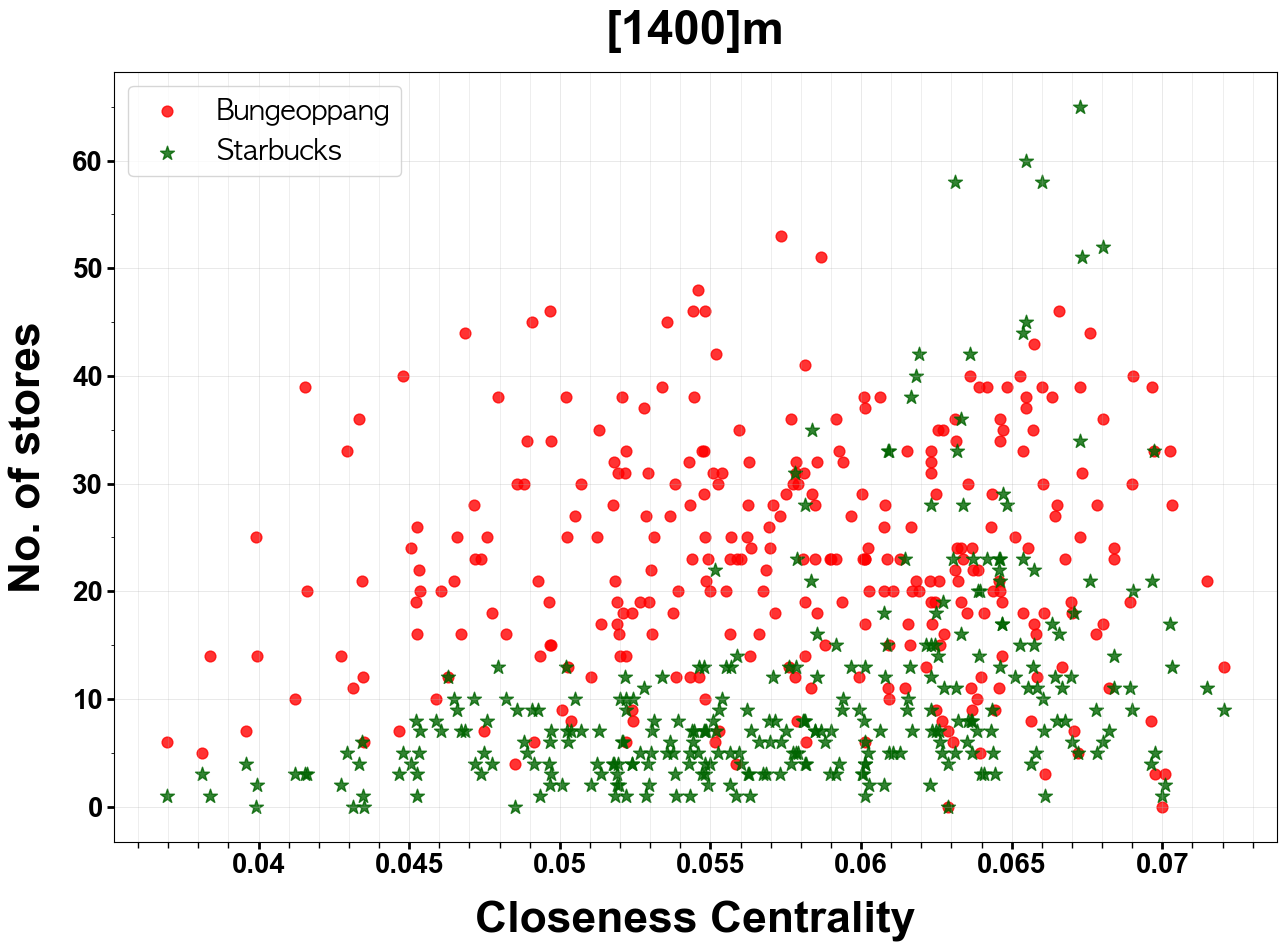

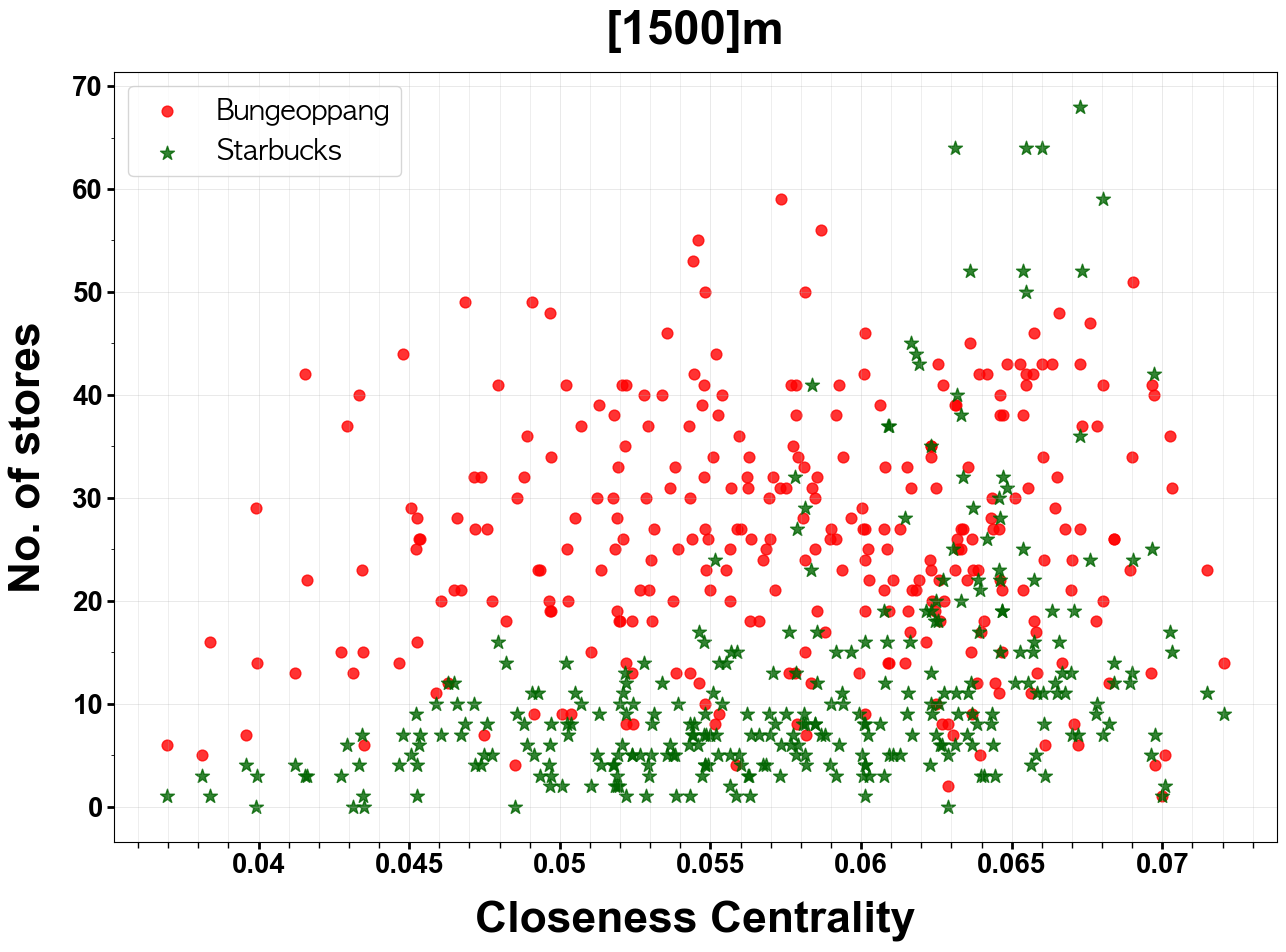

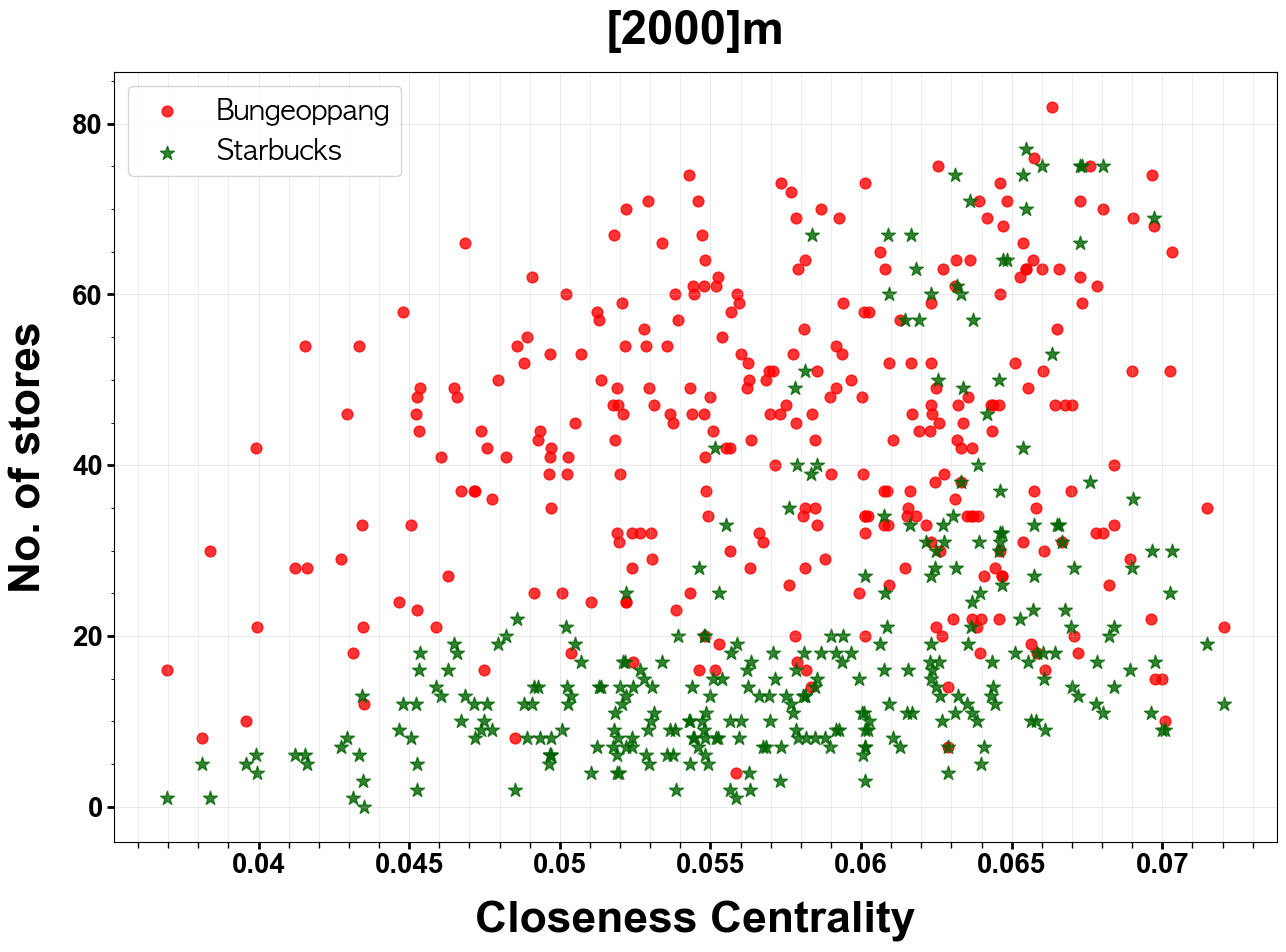

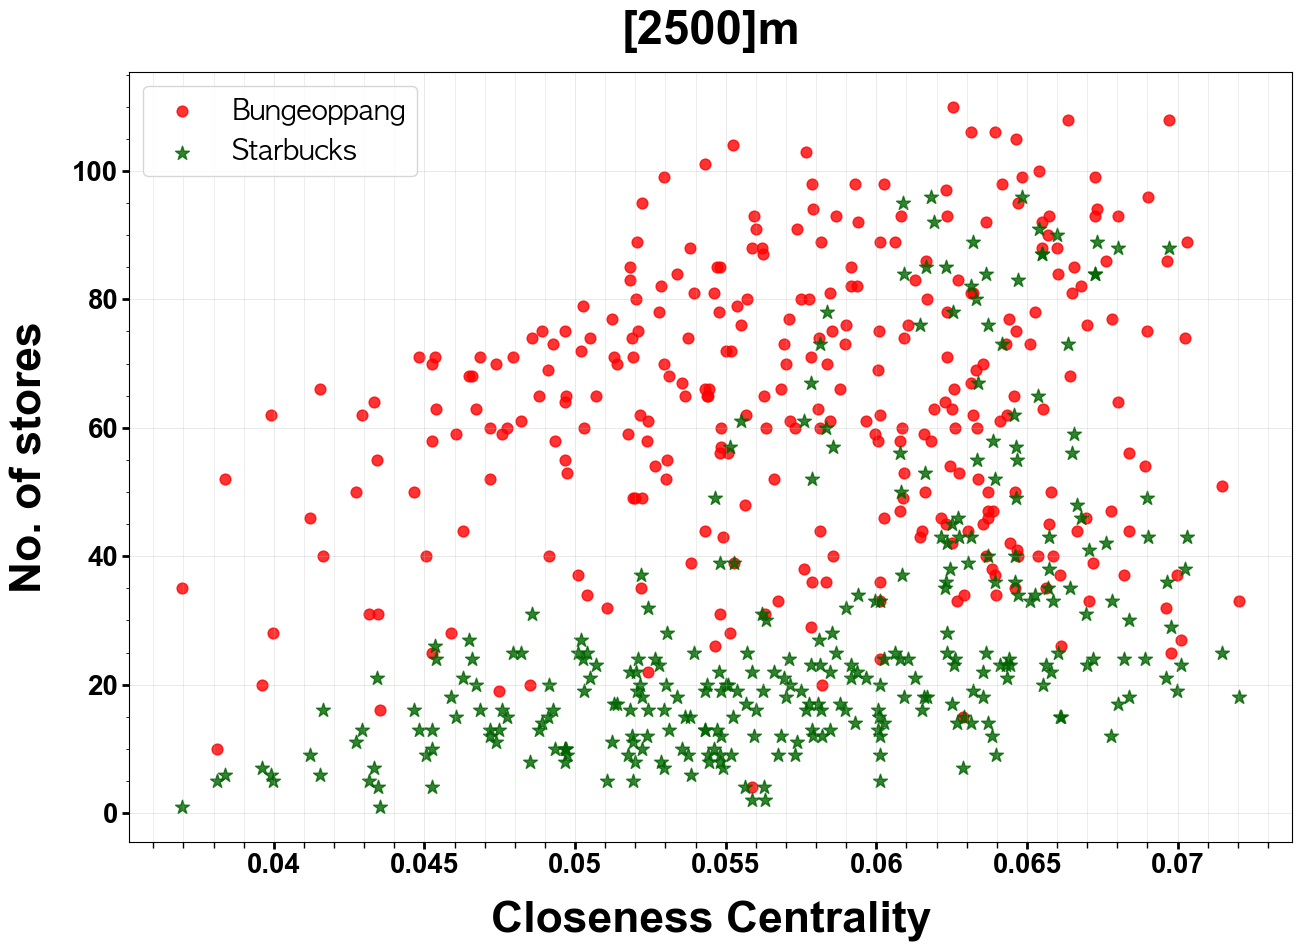

In [ ]:
'''
1.반경을 바꾸기 용이할 것
2. 역을 바꾸기 용이할 것
3. 후에 거리의 역수 개수를 가져와서 그리기 용이할 것'''

"""붕어빵과 스타벅스의 거리별 개수를 CC_x축, 개수_y축 Scatter
pearson, kendall 상관관계와 p-value
총 count된 판매점 개수(중복), 실제 판매점 개수, 비율을 표시"""

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import stats
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
rc('font', family = 'Arial') #실행환경이 Mac일 경우
np.set_printoptions(legacy='1.13') #np.어쩌구 표시를 안하게 하기
# os.chdir(os.path.dirname(__file__))

tai1_count_df = pd.read_excel('/Volumes/YAHO_/006.일일 보관/INPUTS_update_0417/붕어빵_300_2500_all_count_tai.xlsx')
tai2_count_df = pd.read_excel('/Volumes/YAHO_/006.일일 보관/INPUTS_update_0417/스타벅스_300_2500_all_count_tai.xlsx')
# tai1_count_df = pd.read_excel('20250203_dagn_Apr10_최소반경수정100_all_countDistance_tai.xlsx')
# tai2_count_df = pd.read_excel('Starbucks_Apr10_최소반경수정100_all_countDistance_tai.xlsx')
station_df = pd.read_excel('/Volumes/YAHO_/006.일일 보관/INPUTS_update_0417/20250205_서울시내 역(station_df, cent_df 통합).xlsx')

# print(tai1_count_df.head()) #데이터 잘 불러왔는지 확인용


def CC_TAI(station_df, tai_count_df, radius):
    station_labels = station_df['역사명']
    # print(station_labels)
    # tai1_labels = tai1_count_df['역사명']
    df = []
    x = []
    y = []
    for station in station_labels :
        cc = station_df[station_df['역사명'] == station]['Closeness Centrality'].values[0]
        # print(f'{station} : {cc}')
        tai_count = tai_count_df[tai_count_df['역사명'] == station][radius].values[0]
        # print(f'{station} : {tai_count}')
        # x, y  = cc, tai_count
        df.append([x, y])
        x.append(cc)
        y.append(tai_count)
    return x, y ,df
    

def Scatter_tai_tai(radius_m, save = False):
    tai1_x, tai1_y, tai1_df = CC_TAI(station_df=station_df, tai_count_df=tai1_count_df, radius = radius_m)
    tai2_x, tai2_y, tai2_df = CC_TAI(station_df=station_df, tai_count_df=tai2_count_df, radius = radius_m)

    #! 폰트 크기(제목과 축 이름은 전부 굵게)
    title_font = {
    'fontsize': 34,
    'fontweight': 1000
    }
    label_font = {
    'fontsize' : 32
    ,'fontweight':1000

    }
    plt.figure(figsize=(15, 10))
    plt.subplot()
    # scatter line
    # plt.scatter(tai1_x, tai1_y, alpha=1,facecolors='none',edgecolors='red')
    # plt.scatter(tai2_x, tai2_y,marker = '*', s=90, alpha=1, facecolors='none',edgecolors='darkgreen')
    # scatter fill
    plt.scatter(tai1_x, tai1_y, alpha=0.8,s = 60, c = 'red', marker = 'o')
    plt.scatter(tai2_x, tai2_y,marker = '*', s=110, alpha=0.8, c = 'darkgreen')
    plt.title(f'[{radius_m}]m', fontdict=title_font, pad=20, loc='center')
    # plt.ylim(0,0.002)
    
    plt.xlabel('Closeness Centrality', fontdict=label_font, labelpad= 16)
    plt.ylabel('No. of stores', fontdict=label_font, labelpad= 16)
    
    ax = plt.gca()
    plt.legend(['Bungeoppang', 'Starbucks'], loc='upper left',prop={'family':'AppleGothic', 'weight': 'bold','size':20})
    # plt.tight_layout(w_pad=15)
    ax.xaxis.set_minor_locator(MultipleLocator(0.001)) #! x축 눈금 간격 설정
    ax.yaxis.set_minor_locator(MultipleLocator(5)) #! y축 눈금 간격 설정
    plt.tick_params(axis = 'y' , which = 'major' , width = 2, length = 5, pad = 3, labelsize = 18)
    plt.tick_params(axis = 'x' , which = 'major' , width = 2, length = 5, pad = 3, labelsize = 18)
    plt.tick_params(axis = 'x' , which = 'minor' , width = 1, length = 4, pad = 3, labelsize = 16)
    ax.set_yticklabels(ax.get_yticks(), fontsize = 20, fontweight = 'bold')
    ax.set_xticklabels(ax.get_xticks(), fontsize = 20, fontweight = 'bold')
    current_y_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(y) for y in current_y_values])
    t,p = stats.pearsonr(tai1_x, tai1_y)
    plt.grid(linestyle='-', linewidth =0.5, alpha = 0.4, which= 'major')
    plt.grid(linestyle='-', linewidth =0.5, alpha = 0.3, which= 'minor', axis = 'x')
    # plt.text(0.51, 1.13, f'붕어빵| Pearson| r : {t:.4f}, p-value: {p:.4g}', transform=plt.gca().transAxes, fontweight = 'bold',font = 'AppleGothic',fontsize=13)

    if save == True:
        plt.savefig(f'Figure S4 Scatter_{radius_m}m.png')
    else:
        plt.show()
#todo
# Scatter_tai_tai(radius_m=300)
for column in np.arange(300, 1510, 100):
    Scatter_tai_tai(radius_m=column, save = True)
for column in [2000,2500]:
    Scatter_tai_tai(radius_m=column, save = True)


## Figure 수정_ Jul11 사항
- JSD figure의 범위를 0m부터 

IndexError: list index out of range

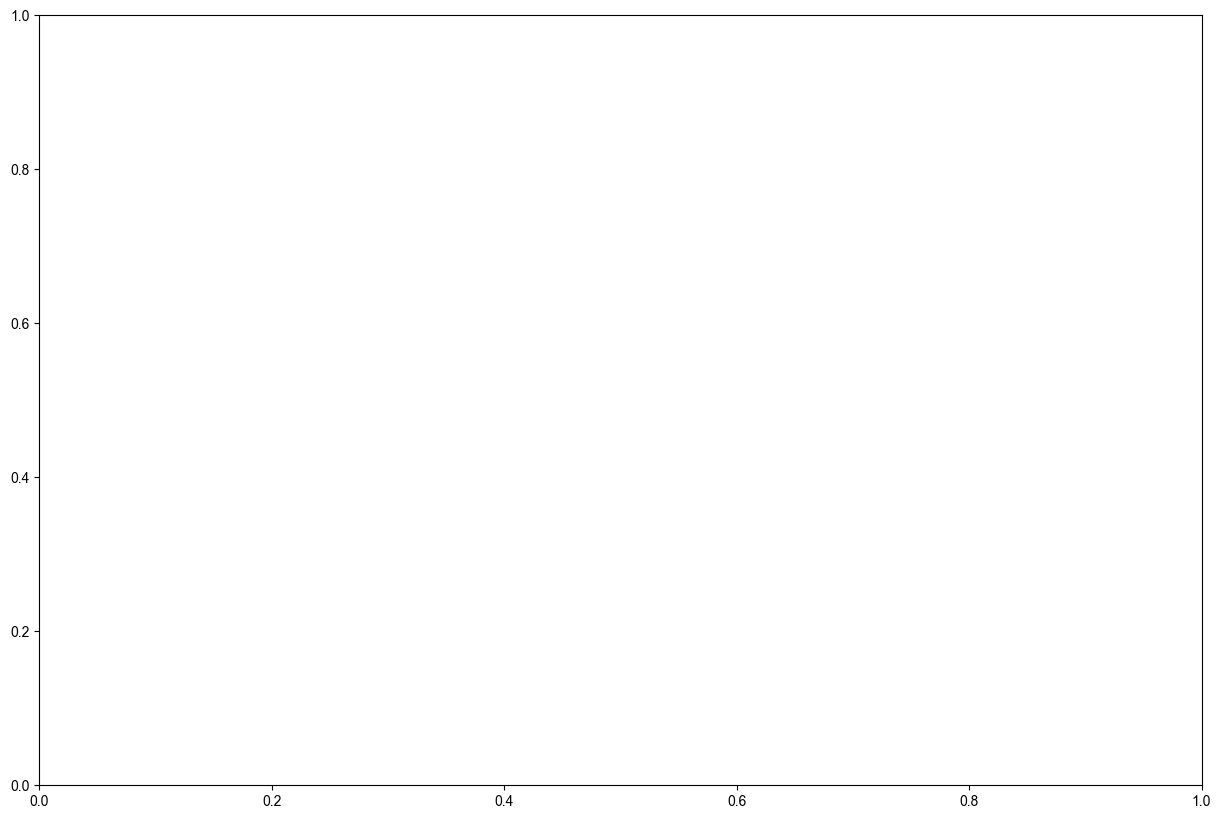

In [6]:

import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import pandas as pd
import os
from matplotlib.ticker import MultipleLocator, IndexLocator, FuncFormatter, LogLocator, FixedLocator
np.set_printoptions(legacy='1.21') #np.어쩌구 표시를 안하게 하기

# rc('font', family = 'AppleGothic') #실행환경이 Mac일 경우
rc('font', family = 'Arial')

# rc('font', family = 'NanumGothic') #실행환경이 Windows일 경우

os.chdir(os.path.dirname(__file__))
count_columns = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,2000,2500] #모든 거리에 대한 for문을 하기 편하게 하기 위한 설정
# radius_km_list = np.arange(0.3, 1.6, 0.1)
# print(os.listdir("../Inputs"))
'''일단 히스토그램을 그리는 것부터 시작하자.
어떤 데이터든지, 일단 히스토그램을 여러개 겹쳐 그리는 것을...'''
cent_df = pd.read_excel('/Volumes/YAHO_/000. Processing Python/붕어빵/Inputs/20250205_서울시내 역(station_df, cent_df 통합).xlsx')
# JSD_DF  = pd.read_excel(Outputs + 'JSD(Cent_df) station~random_all.xlsx')
tai_mean = pd.read_excel('/Volumes/YAHO_/006.일일 보관/0328/JSD수정본 대표값_JSD 10~1510m tai_mean_to_excel.xlsx')
starbucks_mean = pd.read_excel('/Volumes/YAHO_/006.일일 보관/0328/대표값_스타벅스.xlsx')
tai_star_JSD = pd.read_excel('/Volumes/YAHO_/006.일일 보관/0415/250415_JSD_스타벅스_붕어빵.xlsx')
tai_star_JSD_T = pd.read_excel('/Volumes/YAHO_/006.일일 보관/0416/250416_JSD_스타벅스_붕어빵(붕어빵).xlsx')
tai_star_JSD_S = pd.read_excel('/Volumes/YAHO_/006.일일 보관/0416/250416_JSD_스타벅스_붕어빵(스타벅스).xlsx')

tai1_count_df = pd.read_excel('/Volumes/YAHO_/006.일일 보관/0415/붕어빵_300_2500_all_count_tai.xlsx')
tai2_count_df = pd.read_excel('/Volumes/YAHO_/006.일일 보관/0415/스타벅스_300_2500_all_count_tai.xlsx')
# tai_count = pd.read_excel('20250203_Count.xlsx')
# starbucks_count = pd.read_excel('스타벅스_all_count_tai.xlsx')


'''normalize확인해서 excelout만 해결하고 그래프 그리기'''
def calcuate_JSD(count_df_P, count_df_Q,column): #cent_df말고 count count끼리의 JSD를 계산하는 함수
    #!기준을 PQ중 큰 쪽으로
    column_dataP = count_df_P[column].to_list()
    column_dataQ = count_df_Q[column].to_list()
    # plt.figure(figsize = (12,6))
    # print(column_dataP)
    # print(column_dataQ)
    # print(f'++============{column_dataP+column_dataQ}')
    max_value = max(column_dataP+column_dataQ)
    # print(column_dataP+column_dataQ)
    # print(f'max_value : {max_value}')
    # max_value = 50
    countsp, _ = np.histogram(column_dataP, bins=max_value)
    countsq, _ = np.histogram(column_dataQ, bins=max_value)
    prob_p_i = countsp / countsp.sum()
    prob_q_i = countsq / countsq.sum()#np.array
    # prob_q_i = [countsq[i]/sum(countsq) for i in range(len(countsq))]#list
    # print(f'prob_p_i : {type(prob_p_i)}')
    # print(f'prob_q_i : {type(prob_q_i)}')
    # print(prob_p_i.sum())
    # print(prob_q_i.sum())
    P = np.asarray(prob_p_i)
    Q = np.asarray(prob_q_i)
    M = []
    for i in range(len(Q)):
        M.append((Q[i]+P[i])/2)
        # print(M)
    M = np.asarray(M)
    # print(M)
    p_d_js = 1/2*(np.nansum(P*(np.log(P)-np.log(M))))
    q_d_js = 1/2*(np.nansum(Q*(np.log(Q)-np.log(M))))
    JSD = p_d_js+q_d_js
    print(f'{column}m JSD = {p_d_js+q_d_js}')
    return JSD
def calcuate_JSD_PQ(count_df_P, count_df_Q,column): #cent_df말고 count count끼리의 JSD를 계산하는 함수
    #!P기준으로 bins 잡기
    column_dataP = count_df_P[column].to_list()
    column_dataQ = count_df_Q[column].to_list()
    # plt.figure(figsize = (12,6))
    # print(column_dataP)
    # print(column_dataQ)
    # print(f'++============{column_dataP+column_dataQ}')
    max_value = max(column_dataP)
    # print(column_dataP+column_dataQ)
    print(f'max_value : {max_value}')
    # max_value = 50
    countsp, _ = np.histogram(column_dataP, bins=max_value)
    countsq, _ = np.histogram(column_dataQ, bins=max_value)
    prob_p_i = countsp / countsp.sum()
    prob_q_i = countsq / countsq.sum()#np.array
    # prob_q_i = [countsq[i]/sum(countsq) for i in range(len(countsq))]#list
    # print(f'prob_p_i : {type(prob_p_i)}')
    # print(f'prob_q_i : {type(prob_q_i)}')
    # print(prob_p_i.sum())
    # print(prob_q_i.sum())
    P = np.asarray(prob_p_i)
    Q = np.asarray(prob_q_i)
    M = []
    for i in range(len(Q)):
        M.append((Q[i]+P[i])/2)
        # print(M)
    M = np.asarray(M)
    # print(M)
    p_d_js = 1/2*(np.nansum(P*(np.log(P)-np.log(M))))
    q_d_js = 1/2*(np.nansum(Q*(np.log(Q)-np.log(M))))
    JSD = p_d_js+q_d_js
    print(f'{column}m JSD = {p_d_js+q_d_js}')
    return JSD    

def calcuate_JSD_CC(count_df_P, cent_df,column): 
    column_data = count_df_P[column]
    column_dataq = cent_df['Closeness Centrality']
    plt.figure(figsize = (12,6))
    max_value = column_data.max()+1
    counts, _ = np.histogram(column_data, bins=max_value)
    countsq, _ = np.histogram(column_dataq, bins=max_value)
    prob_p_i = counts / counts.sum()
    prob_q_i = [countsq[i]/sum(countsq) for i in range(len(countsq))]
    P = np.asarray(prob_p_i)
    Q = np.asarray(prob_q_i)
    M = []
    for i in range(len(Q)):
        M.append((Q[i]+P[i])/2)
        # print(M)
    M = np.asarray(M)
    # print(M)
    p_d_js = 1/2*(np.nansum(P*(np.log(P)-np.log(M))))
    q_d_js = 1/2*(np.nansum(Q*(np.log(Q)-np.log(M))))
    JSD = p_d_js+q_d_js
    print(f'{column}m JSD = {p_d_js+q_d_js}')
    return JSD
# calcuate_JSD(tai_count, starbucks_count, 1000) #1000m에 대한 JSD를 계산해보자
# calcuate_JSD(starbucks_count,tai_count, 1000) #1000m에 대한 JSD를 계산해보자

# JSD_dict = {}
# for column in count_columns:
#     JSD = calcuate_JSD_PQ(tai1_count_df, tai2_count_df, column) 
#     # calcuate_JSD(starbucks_count, tai_count, column)
#     JSD_dict[column] = JSD
# pd.DataFrame(JSD_dict.items(), columns=['radius_m', 'JSD']).to_excel('250416_JSD_스타벅스_붕어빵(붕어빵).xlsx', index=False)
# JSD_dict = {}
# for column in count_columns:
#     JSD = calcuate_JSD_PQ(tai2_count_df, tai1_count_df, column) 
#     # calcuate_JSD(starbucks_count, tai_count, column)
#     JSD_dict[column] = JSD
# pd.DataFrame(JSD_dict.items(), columns=['radius_m', 'JSD']).to_excel('250416_JSD_스타벅스_붕어빵(스타벅스).xlsx', index=False)


# JSD_dict = {}
# for column in count_columns:
#     JSD = calcuate_JSD_CC(tai1_count_df, cent_df, column) 
#     # calcuate_JSD(starbucks_count, tai_count, column)
#     JSD_dict[column] = JSD
# pd.DataFrame(JSD_dict.items(), columns=['radius_m', 'JSD']).to_excel('250417_JSD_CC붕어빵.xlsx', index=False)
# JSD_dict = {}
# for column in count_columns:
#     JSD = calcuate_JSD_CC(tai2_count_df,cent_df, column) 
#     # calcuate_JSD(starbucks_count, tai_count, column)
#     JSD_dict[column] = JSD
# pd.DataFrame(JSD_dict.items(), columns=['radius_m', 'JSD']).to_excel('250417_JSD_CC스타벅스.xlsx', index=False)
    
start =300
end = 1510
count_columns = np.arange(start,end,100)

fig, ax = plt.subplots()
fig.set_size_inches(15,10) # 3:2 비율
#! 폰트 크기(제목과 축 이름은 전부 굵게)
title_font = {
'fontsize': 36,
'fontweight': 'black'
}
label_font = {
'fontsize' : 34
,'fontweight':'black'

}
fig.set_figwidth(15)
fig.set_figheight(10)
# plt.figure(figsize=(16,10))
# ax.grid(linestyle='-', linewidth =0.5, alpha = 0.5, which= 'both')
JSD_tai = []
for i in count_columns:
    jsd = tai_mean.loc[tai_mean['radius_m'] == int(i), 'JSD'].to_list()[0]
    JSD_tai.append(jsd)
# print(JSD_tai)
JSD_starbucks = []
for i in count_columns:
    jsd = starbucks_mean.loc[starbucks_mean['radius_m'] == int(i), 'JSD'].to_list()[0]
    JSD_starbucks.append(jsd)
JSD_tai_star_T = []
count_columns_2 = [300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,2000,2500] #모든 거리에 대한 for문을 하기 편하게 하기 위한 설정

for i in count_columns:
    jsd = tai_star_JSD_T.loc[tai_star_JSD_T['radius_m'] == int(i), 'JSD'].to_list()[0]
    JSD_tai_star_T.append(jsd)
    
JSD_tai_star_S = []
for i in count_columns:
    jsd = tai_star_JSD_S.loc[tai_star_JSD_S['radius_m'] == int(i), 'JSD'].to_list()[0]
    JSD_tai_star_S.append(jsd)
tai_star_JSD = tai_star_JSD['JSD'].to_list()
# JSD_starbucks = starbucks_mean["JSD"].to_list()
print(JSD_tai_star_T)
print(JSD_tai_star_S)
print(tai_star_JSD)
# plt.plot(count_columns, tai_star_JSD,marker = 'o', c = 'gray', label = '붕어빵과 스타벅스의 JSD', linewidth = 6 ,markersize=10)
# plt.plot(count_columns, JSD_tai_star_T,marker = '^', c = '#DAA520', label = '붕어빵과 스타벅스의 JSD(붕어빵)', linewidth = 2 ,markersize=10)
# plt.scatter([2000,2500],[0.3143,0.365991], marker= '^', c = '#DAA520', s = 100)

# plt.plot(count_columns, JSD_tai_star_S,marker = '^', c = 'blue', label = '붕어빵과 스타벅스의 JSD(스타벅스)', linewidth = 2 ,markersize=5)
# plt.scatter([2000,2500],[0.285415,0.33149], marker= '^', c = 'blue', s = 100)

plt.plot(count_columns,JSD_starbucks,marker = 'D', c = '#008000', label = 'Starbucks-Closeness centrality', linewidth = 5 ,markersize=15)
plt.scatter([2000,2500],[0.347106927,0.313158134], marker= 'D', c = '#008000', s = 150)
plt.plot(count_columns, JSD_tai,marker = 'o', c = 'red', label = '붕어빵-Closeness centrality', linewidth = 5 ,markersize=17)
plt.scatter([2000,2500],[0.098628801,0.107386729], marker= 'o', c = 'red', s = 170)


ax.xaxis.set_major_locator(MultipleLocator(500))
ax.xaxis.set_minor_locator(MultipleLocator(100))
# ax.xaxis.set_major_formatter(FuncFormatter(plt_tick_log))
ax.tick_params(axis = 'x', which = 'minor' , width = 1.5, length = 5, direction = 'out' , labelsize = 20, pad = 10)
ax.tick_params(axis = 'x', which = 'major' , width = 2, length = 5, direction = 'inout' , labelsize = 20, pad = 10)
ax.set_yticklabels(ax.get_yticks(), fontsize = 20, fontweight = 'bold')
ax.set_xticklabels(ax.get_xticks(), fontsize = 20, fontweight = 'bold')
ax.tick_params(axis = 'y' , which = 'major' , width = 2, length = 5, pad = 3, labelsize = 20)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}'))  # 실제 값 표시
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))  # 실제 값 표시
#? minor 눈금은 100미터 단위 표시
# ax.yaxis.set_minor_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))  # 실제 값 표시
# ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# tick_locations = []
# ax.tick_params(axis = 'y' , which = 'minor' , width = 0.5, length = 3, labelsize = 14)


    
# plt.get_figlabels
plt.yticks(np.arange(0.00, 0.55, 0.1 ))
plt.xticks(np.arange(0, 2510, 500 ))
# plt.xticks(np.arange(start,end,50))
# ax.set_xticklabels(['{:g}m'.format(x) for x in np.arange(start,end,50)])
# plt.title('붕어빵 판매점과 스타벅스 지점 분포의 JSD 비교', fontdict= title_font, pad = 20)
plt.ylabel('Jensen-Shanon Divergence', fontdict=label_font, labelpad= 20)
# plt.xlabel('Radius (m)', fontdict=label_font, labelpad= 14)
ax.legend(loc='lower left',prop={'family':'AppleGothic', 'weight': 'bold','size':14})
# ax.legend(loc='lower left',prop={'family':'AppleGothic', 'weight': 'bold','size':14})
ax.set_xlim(1300,2600)#2000,2500포인트
# ax.set_xlim(200,1550)#300~1500포인트
plt.show()



# pearson 수정사항

In [7]:
'''
1.반경을 바꾸기 용이할 것
2. 역을 바꾸기 용이할 것
3. 후에 거리의 역수 개수를 가져와서 그리기 용이할 것'''

"""붕어빵과 스타벅스의 거리별 개수를 CC_x축, 개수_y축 Scatter
pearson, kendall 상관관계와 p-value
총 count된 판매점 개수(중복), 실제 판매점 개수, 비율을 표시"""

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import stats
from matplotlib import rc
from matplotlib.ticker import MultipleLocator,FuncFormatter
rc('font', family = 'Arial') #실행환경이 Mac일 경우
np.set_printoptions(legacy='1.13') #np.어쩌구 표시를 안하게 하기
os.chdir(os.path.dirname(__file__))

taiOne_count_df = pd.read_excel('/Volumes/YAHO_/006.일일 보관/INPUTS_update_0417/붕어빵_300_2500_all_count_tai_2.xlsx')
taiTwo_count_df = pd.read_excel('/Volumes/YAHO_/006.일일 보관/INPUTS_update_0417/스타벅스_300_2500_all_count_tai_2.xlsx')
# taiOne_count_df = pd.read_excel('/Volumes/YAHO_/999.용도별 코드_Input포함/붕어빵_100_3000_all_count_tai.xlsx')
# taiTwo_count_df = pd.read_excel('/Volumes/YAHO_/999.용도별 코드_Input포함/스타벅스_100_3000_all_count_tai.xlsx')
cent_df = pd.read_excel('/Volumes/YAHO_/006.일일 보관/INPUTS_update_0417/20250205_서울시내 역(station_df, cent_df 통합).xlsx')

# print(taiOne_count_df.head()) #데이터 잘 불러왔는지 확인용
# print(taiTwo_count_df.head()) #데이터 잘 불러왔는지 확인용
# print(cent_df.head()) #데이터 잘 불러왔는지 확인용


def CC_TAI(station_df, tai_count_df, radius):#x축 CC, y축 판매점 개수
    station_labels = station_df['역사명']
    # print(station_labels)
    # taiOne_labels = taiOne_count_df['역사명']
    xy = []
    x = []
    y = []
    for station in station_labels :
        cc = station_df[station_df['역사명'] == station]['Closeness Centrality'].values[0]
        # print(f'{station} : {cc}')
        tai_count = tai_count_df[tai_count_df['역사명'] == station][radius].values[0]
        # print(f'{station} : {tai_count}')
        # x, y  = cc, tai_count
        xy.append([x, y])
        x.append(cc)
        y.append(tai_count)
    return x, y ,xy
def Pearson_tai(cent_df, tai_df, radius):
    cc_x, tai_y, tai_df = CC_TAI(cent_df, tai_df, radius)
    r, p = stats.pearsonr(cc_x, tai_y)
    return r, p

def Kendall_tai(cent_df, tai_df, radius):
    cc_x, tai_y, tai_df = CC_TAI(cent_df, tai_df, radius)
    t, p = stats.kendalltau(cc_x, tai_y)
    return t, p

def Fig_Pearson_tai_tai(taiOne_df,taiTwo_df, count_columns):
    # plt.figure(figsize=(12, 9))
    fig, ax = plt.subplots()
    fig.set_figwidth(13)
    fig.set_figheight(10)
    
        #! 폰트 크기(제목과 축 이름은 전부 굵게)
    title_font = {
    'fontsize': 34,
    'fontweight': 1000
    }
    label_font = {
    'fontsize' : 32
    ,'fontweight':1000

    }
    # scatter line
    # plt.scatter(taiOne_x, taiOne_y, alpha=1,facecolors='none',edgecolors='red')
    # plt.scatter(taiTwo_x, taiTwo_y,marker = '*', s=90, alpha=1, facecolors='none',edgecolors='darkgreen')
    # scatter fill
    # plt.grid(linestyle='-', linewidth =0.5, alpha = 0.5, which= 'both')
    # plt.title(f'            [{radius_m}]m', fontdict=title_font, pad=20, loc='left')
    # plt.ylim(0,0.002)
    
    plt.xlabel('Radius(m)', fontdict=label_font, labelpad= 16)
    plt.ylabel('Pearson correlation coefficient', fontsize = 36, fontweight = 1000, labelpad= 14)
    
    
    # ax = plt.gca()
    # plt.tight_layout(w_pad=1)
    plt.xticks(np.arange(0, 1600, 100))
    ax.set_yticklabels(ax.get_yticks(), fontsize = 20, fontweight = 'bold')
    ax.set_xticklabels(ax.get_xticks(), fontsize = 20, fontweight = 'bold')
    ax.xaxis.set_major_locator(MultipleLocator(500))
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    # ax.yaxis.set_minor_locator(MultipleLocator(0.01))
    ax.tick_params(axis = 'y' , which = 'major' , width = 2, length = 8, pad = 3, labelsize = 20)
    ax.tick_params(axis = 'y' , which = 'minor' , width = 1, length = 5, pad = 3, labelsize = 20)
    ax.tick_params(axis = 'x' , which = 'major' , width = 2, length = 6, pad = 3, labelsize = 22)
    ax.tick_params(axis = 'x', which = 'minor' , width = 1.5, length = 5, direction = 'out' , labelsize = 20, pad = 10)
    
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}'))  # 실제 값 표시
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))  # 실제 값 표시
    # ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # x축 정수로 표시
    
    for column in count_columns:
        taiOne_pr, taiOne_pp = Pearson_tai(cent_df=cent_df, tai_df=taiOne_df, radius = column)
        print(f"붕어빵| 피어슨(선형) | r : {taiOne_pr}, p-value: {taiOne_pp}")
        taiTwo_pr, taiTwo_pp = Pearson_tai(cent_df=cent_df, tai_df=taiTwo_df, radius = column)
        print(f"스타벅스| 피어슨(선형) | r : {taiTwo_pr}, p-value: {taiTwo_pp}")
        plt.scatter(column, taiTwo_pr,marker = '*', s= 240, alpha=1, c = 'darkgreen')
        plt.scatter(column, taiOne_pr,marker = 'o', s= 130, alpha=1,c = 'red')
        # todo 이제 대충 보여주고, 제대로 나오는지 확인하면 레이아웃 수정하자..
    leg = plt.legend(['Starbucks','Bungeoppang'], loc='upper left',prop={'family':'AppleGothic', 'weight': 'bold','size':20})

    for handle in leg.legend_handles:
        handle.set_alpha(1)  # legend 마커만 alpha 조절
    # plt.legend(['스타벅스','붕어빵'], loc='upper left',prop={'family':'AppleGothic', 'weight': 'bold','size':20})
    ax.set_xlim(00,1600)
    # ax.set_xlim(1300,2600)
    ax.set_ylim(-0.1,0.7)
    plt.show()

def Fig_Kendalltau_tai_tai(taiOne_df,taiTwo_df, count_columns):
    fig, ax = plt.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(10)
    
        #! 폰트 크기(제목과 축 이름은 전부 굵게)
    title_font = {
    'fontsize': 34,
    'fontweight': 1000
    }
    label_font = {
    'fontsize' : 32
    ,'fontweight':1000

    }
    
    plt.xlabel('Radius(m)', fontdict=label_font, labelpad= 16)
    plt.ylabel('Kendall correlation coefficient', fontsize = 36, fontweight = 1000, labelpad= 14)
    
    
    # plt.tight_layout(w_pad=1)
    plt.xticks(np.arange(0, 1600, 100))
    ax.set_yticklabels(ax.get_yticks(), fontsize = 20, fontweight = 'bold')
    ax.set_xticklabels(ax.get_xticks(), fontsize = 20, fontweight = 'bold')
    ax.xaxis.set_major_locator(MultipleLocator(500))
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.yaxis.set_minor_locator(MultipleLocator(0.01))
    ax.tick_params(axis = 'y' , which = 'major' , width = 2, length = 8, pad = 3, labelsize = 20)
    ax.tick_params(axis = 'y' , which = 'minor' , width = 1, length = 5, pad = 3, labelsize = 20)
    ax.tick_params(axis = 'x' , which = 'major' , width = 2, length = 6, pad = 3, labelsize = 22)
    ax.tick_params(axis = 'x', which = 'minor' , width = 1.5, length = 5, direction = 'out' , labelsize = 20, pad = 10)
    
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}'))  # 실제 값 표시
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))  # 실제 값 표시
    # ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # x축 정수로 표시
    
    for column in count_columns:
        taiOne_kt, taiOne_kp = Kendall_tai(cent_df=cent_df, tai_df=taiOne_df, radius = column)
        print(f"붕어빵| 켄달타우(순위) | r : {taiOne_kt}, p-value: {taiOne_kp}")
        taiTwo_kt, taiTwo_kp = Kendall_tai(cent_df=cent_df, tai_df=taiTwo_df, radius = column)
        print(f"스타벅스| 켄달타우(순위) | r : {taiTwo_kt}, p-value: {taiTwo_kp}")
        plt.scatter(column, taiTwo_kt,marker = '*', s=240, alpha=0.8, c = 'darkgreen')
        plt.scatter(column, taiOne_kt, alpha=0.8, s = 130,c = 'red', marker = 'o')
        # todo 이제 대충 보여주고, 제대로 나오는지 확인하면 레이아웃 수정하자..
    plt.legend(['스타벅스','붕어빵'], loc='upper left',prop={'family':'AppleGothic', 'weight': 'bold','size':20})
    # ax.set_xlim(200,1600)
    ax.set_xlim(1300,2600)
    ax.set_ylim(-0.1,0.5)
    plt.show()

#todo==========
Fig_Pearson_tai_tai(taiOne_df=taiOne_count_df,taiTwo_df=taiTwo_count_df,count_columns=np.arange(100,1510,100))#테스트용
# Fig_Kendalltau_tai_tai(taiOne_df=taiOne_count_df,taiTwo_df=taiTwo_count_df,count_columns=np.arange(300,1510,100))#테스트용
# Fig_Pearson_tai_tai(taiOne_df=taiOne_count_df,taiTwo_df=taiTwo_count_df,count_columns=[2000,2500])#테스트용
# Fig_Kendalltau_tai_tai(taiOne_df=taiOne_count_df,taiTwo_df=taiTwo_count_df,count_columns=[2000,2500])#테스트용


NameError: name '__file__' is not defined